In [1]:
import sys
sys.path.append('/home/alexander/Desktop/univer/BrandNewResearch')

from collections import defaultdict

from MyPackage.Models.SelkovStrogatz1D.SelkovStrogatz1DConfiguration import SelkovStrogatz1DConfiguration
from MyPackage.Models.SelkovStrogatz1D.SelkovStrogatz1DTdmaSolver import integrate_tdma_implicit_scheme, TdmaParameters1D
from MyPackage.MathHelpers.InitDataHelpers import *

from MyPackage.Drawing.DrawTransient1D import draw_transient
from MyPackage.Drawing.DrawHelper import set_defaults_1D
from MyPackage.ResearchHelpers.UsefulNotebookDrawings import draw_quadreega
from MyPackage.DataAnalyzers.PeaksAnalyzer import calc_presence
from MyPackage.DataContainers.Experiment import Experiment
from MyPackage.DataContainers.ExperimentHelper import read_experiments_from_dir

from MyPackage.DataAnalyzers.PeaksAnalyzer import calc_peaks_by_Fourier

import pylab as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm


%load_ext autoreload

%autoreload 2

In [2]:
set_defaults_1D()
FOURIER_KS = [round(x / 2, 1) for x in range(1,21)]

# Грузим данные

In [11]:
exps_big_range = read_experiments_from_dir('/media/alexander/BigDisk/data/fst_selk_strogg_2023_01_22_range_5')

Processing /media/alexander/BigDisk/data/fst_selk_strogg_2023_01_22_range_5/9000_10009: : 88000it [22:55, 63.99it/s]  


In [12]:
exps = read_experiments_from_dir('/media/alexander/BigDisk/data/fst_selk_strogg_2023_01_22')

Processing /media/alexander/BigDisk/data/fst_selk_strogg_2023_01_22/9000_10002: : 88000it [23:47, 61.63it/s]  


In [13]:
params_to_exps = defaultdict(list)

In [14]:
for e in exps_big_range:
    conf = e.model_config
    params_to_exps[(conf['a'], conf['b'])].append(e)

In [15]:
for k, v in params_to_exps.items():
    assert len(v) == 500, str(k)

In [16]:
params_to_exps.keys()

dict_keys([(0.0025, 0.6), (0.0025, 0.7), (0.0025, 0.65), (0.0025, 0.8), (0.0025, 0.75), (0.0025, 0.85), (0.015, 1.0), (0.015, 1.05), (0.015, 1.1), (0.015, 1.15), (0.015, 1.2), (0.015, 1.25), (0.015, 1.3), (0.015, 1.35), (0.0275, 0.6), (0.0275, 0.65), (0.0025, 0.9), (0.0025, 0.95), (0.0025, 1.0), (0.0025, 1.05), (0.0025, 1.1), (0.0025, 1.15), (0.0525, 0.7), (0.0025, 1.2), (0.0025, 1.25), (0.0025, 1.3), (0.0025, 1.35), (0.015, 0.6), (0.015, 0.65), (0.09, 1.3), (0.015, 0.7), (0.015, 0.75), (0.015, 0.8), (0.015, 0.85), (0.015, 0.9), (0.015, 0.95), (0.0525, 0.75), (0.0525, 0.8), (0.0525, 0.85), (0.0525, 0.9), (0.0525, 0.95), (0.0525, 1.0), (0.0525, 1.05), (0.0525, 1.1), (0.0275, 0.7), (0.0275, 0.75), (0.0275, 0.8), (0.0275, 0.85), (0.0275, 0.9), (0.0275, 0.95), (0.0275, 1.0), (0.0275, 1.05), (0.0275, 1.1), (0.0275, 1.15), (0.0275, 1.2), (0.0275, 1.25), (0.0275, 1.3), (0.0275, 1.35), (0.04, 0.6), (0.0525, 1.15), (0.065, 1.0), (0.0775, 0.85), (0.09, 0.7), (0.1025, 1.0), (0.115, 0.9), (0.1275,

In [23]:
a_index = {y:i for i,y in enumerate(sorted(set(x[0] for x in params_to_exps)))}
b_index = {y:i for i,y in enumerate(sorted(set(x[1] for x in params_to_exps)))}
a_index, b_index

({0.0025: 0,
  0.015: 1,
  0.0275: 2,
  0.04: 3,
  0.0525: 4,
  0.065: 5,
  0.0775: 6,
  0.09: 7,
  0.1025: 8,
  0.115: 9,
  0.1275: 10},
 {0.6: 0,
  0.65: 1,
  0.7: 2,
  0.75: 3,
  0.8: 4,
  0.85: 5,
  0.9: 6,
  0.95: 7,
  1.0: 8,
  1.05: 9,
  1.1: 10,
  1.15: 11,
  1.2: 12,
  1.25: 13,
  1.3: 14,
  1.35: 15})

# Про Хопфа и Тьюринга

 a in [0.0025, 0.1275], b in [0.6, 1.35]


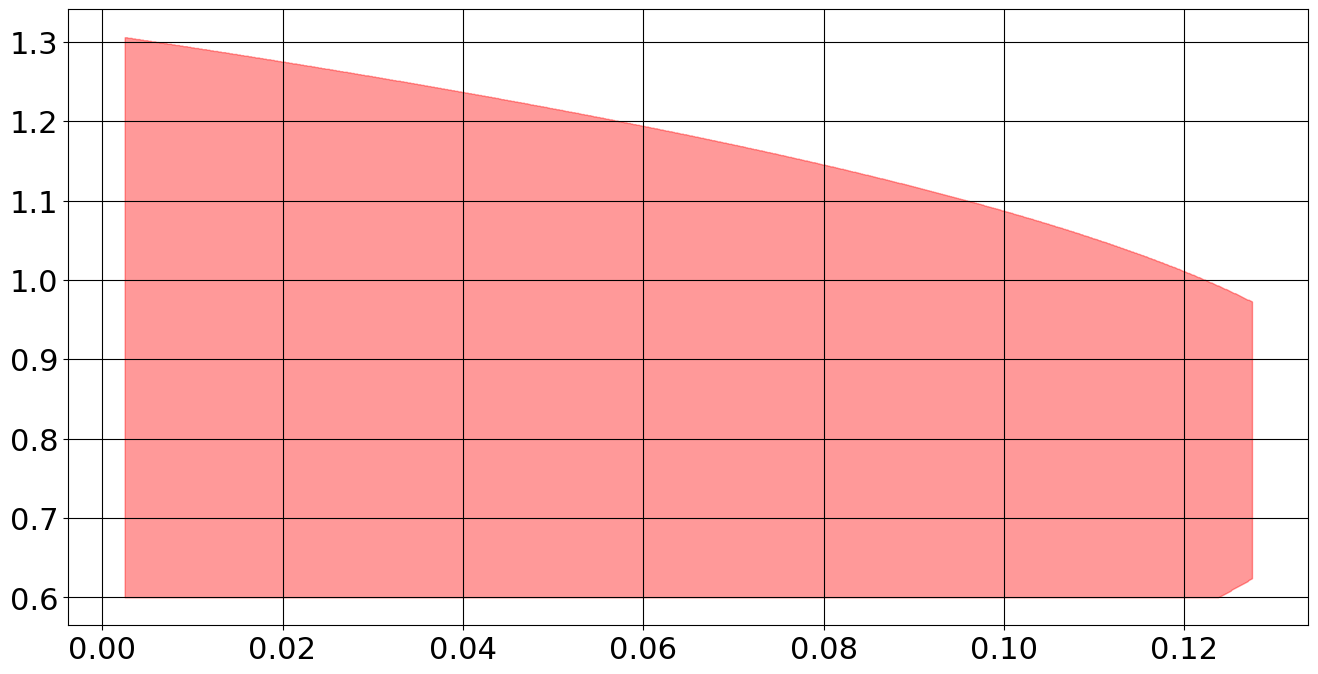

In [105]:
d = 10
aa = np.linspace(min(a_index), max(a_index), 1001)
bb = np.linspace(min(b_index), max(b_index), 1001)

min_a, max_a, min_b, max_b = min(aa), max(aa), min(bb), max(bb)
print(f" a in [{min_a}, {max_a}], b in [{min_b}, {max_b}]")
turing_mins = []
turing_maxs = []
turing_xs = []
for a in aa:
    min_b = None
    max_b = None
    for b in bb:
        if d*(b**2-a) > (b**2 + a)**2 and (d*(b**2-a) - (b**2 + a)**2)**2 > 4*d*(b**2+a)**3:
            if min_b is None:
                min_b = b
        if d*(b**2-a) < (b**2 + a)**2 or (d*(b**2-a) - (b**2 + a)**2)**2 < 4*d*(b**2+a)**3:
            if max_b is None and min_b is not None:
                max_b = b
    if min_b is None or max_b is None or np.isnan(min_b) or np.isnan(max_b):
        continue
    turing_xs.append(a)
    turing_mins.append(min_b)
    turing_maxs.append(max_b)
turing_mins = np.array(turing_mins)
turing_maxs = np.array(turing_maxs)
turing_xs = np.array(turing_xs)
plt.fill_between(turing_xs, turing_mins, turing_maxs, color='r', label = 'turing', alpha=.4)

 a in [0.0025, 0.1275], b in [0.6, 1.35]


/tmp/ipykernel_12663/3236916021.py:12: RuntimeWarning: invalid value encountered in sqrt
  if 2* b**2 >= (-2*a) + 1 - np.sqrt(1-8*a):
/tmp/ipykernel_12663/3236916021.py:15: RuntimeWarning: invalid value encountered in sqrt
  if 2* b**2 >= (-2*a) + 1 + np.sqrt(1-8*a):


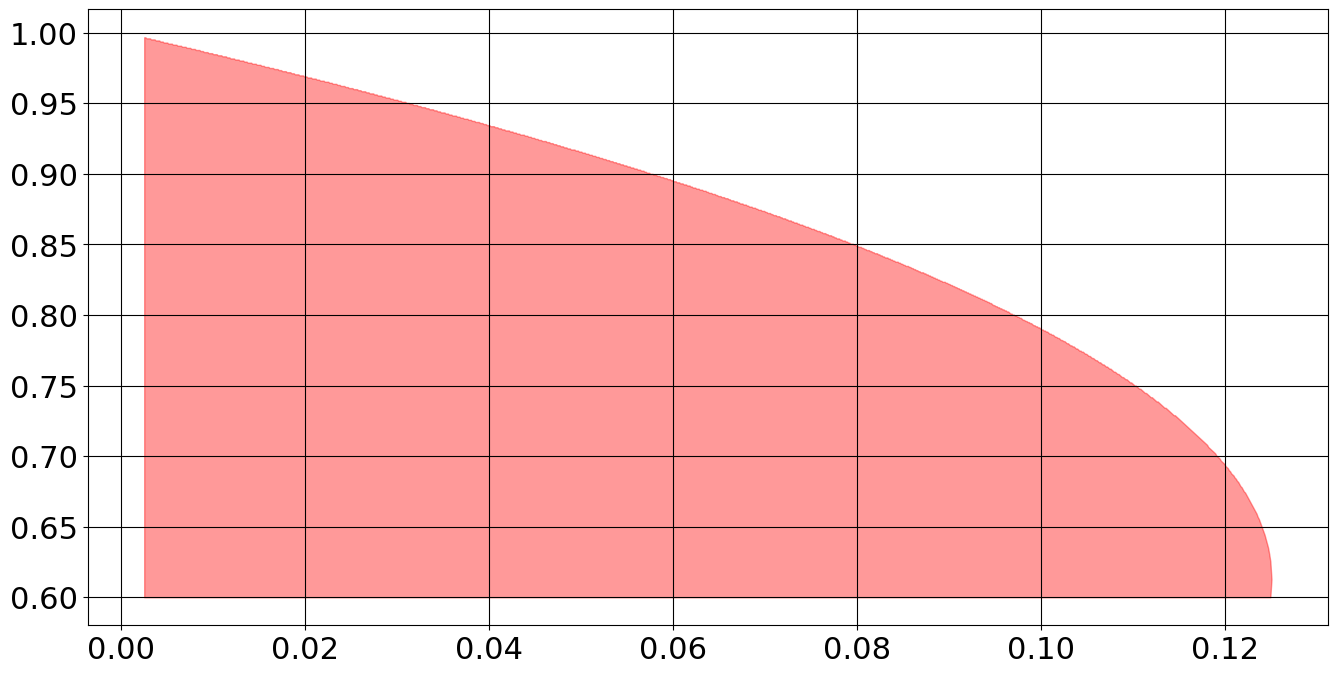

In [104]:
aa = np.linspace(min(a_index), max(a_index), 1001)
bb = np.linspace(min(b_index), max(b_index), 1001)
min_a, max_a, min_b, max_b = min(aa), max(aa), min(bb), max(bb)
print(f" a in [{min_a}, {max_a}], b in [{min_b}, {max_b}]")
hopf_mins = []
hopf_maxs = []
hopf_xs = []
for a in aa:
    min_b = None
    max_b = None
    for b in bb:
        if 2* b**2 >= (-2*a) + 1 - np.sqrt(1-8*a):
            if min_b is None:
                min_b = b
        if 2* b**2 >= (-2*a) + 1 + np.sqrt(1-8*a):
            if max_b is None and min_b is not None:
                max_b = b
    if min_b is None or max_b is None or np.isnan(min_b) or np.isnan(max_b):
        continue
    hopf_xs.append(a)
    hopf_mins.append(min_b)
    hopf_maxs.append(max_b)
hopf_mins = np.array(hopf_mins)
hopf_maxs = np.array(hopf_maxs)
hopf_xs = np.array(hopf_xs)
plt.fill_between(hopf_xs, hopf_mins, hopf_maxs, color='r', label = 'hopf', alpha=.4)

# Картинки

In [29]:
def get_and_draw_stats(exps, draw = False):
    stat_patt = defaultdict(int)
    count_patt = 0
    stat_amp = defaultdict(list)
    if draw:
        ax = plt.gca()
    for e in exps:
        pcks = calc_peaks_by_Fourier(e,var='u', max_peaks_count=10, min_amplitude=0.1)
        if pcks is None:
            continue
        if draw:
            ax.plot(e.end_values['u'])
        stat_patt[(pcks.peaks_count, str(pcks.direction))]+=1
        count_patt+=1
        stat_amp[(pcks.peaks_count, str(pcks.direction))].append(max(e.end_values['u']) - min(e.end_values['u']))
    if draw:
        plt.show()
    stat_patt = {k:stat_patt[k] for k in sorted(stat_patt)}

    amp_mean_max = 0 if not stat_amp else min(sum(x)/len(x) for x in stat_amp.values())
    amp_max_delta = 0 if not stat_amp else max(max(x) - min(x) for x in stat_amp.values())
    amp_mean = np.mean([np.mean(x) for x in stat_amp.values()])
    return count_patt, stat_patt, amp_mean_max, amp_max_delta, amp_mean


In [31]:
patterns_count = np.zeros((len(a_index), len(b_index)))
pattern_types_count = np.zeros((len(a_index), len(b_index)))
patterns_amp_max = np.zeros((len(a_index), len(b_index)))
patterns_amp_delta = np.zeros((len(a_index), len(b_index)))
patterns_amp_mean = np.zeros((len(a_index), len(b_index)))
aaa = set()
for key, value in tqdm(params_to_exps.items()):
    count, stat, amp_mean_max, amp_var, amp_mean = get_and_draw_stats(value)
    #print(stat.keys())
    for a in stat.keys():
        aaa.add(a[0])
    a, b = key
    patterns_count[a_index[a], b_index[b]] += count
    pattern_types_count[a_index[a], b_index[b]] = len(stat)
    patterns_amp_max[a_index[a], b_index[b]] = amp_mean_max
    patterns_amp_delta[a_index[a], b_index[b]] = amp_var
    patterns_amp_mean[a_index[a], b_index[b]] = amp_mean



100%|██████████| 176/176 [00:15<00:00, 11.14it/s]


[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5]
[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5]


(0.0, 10.5)

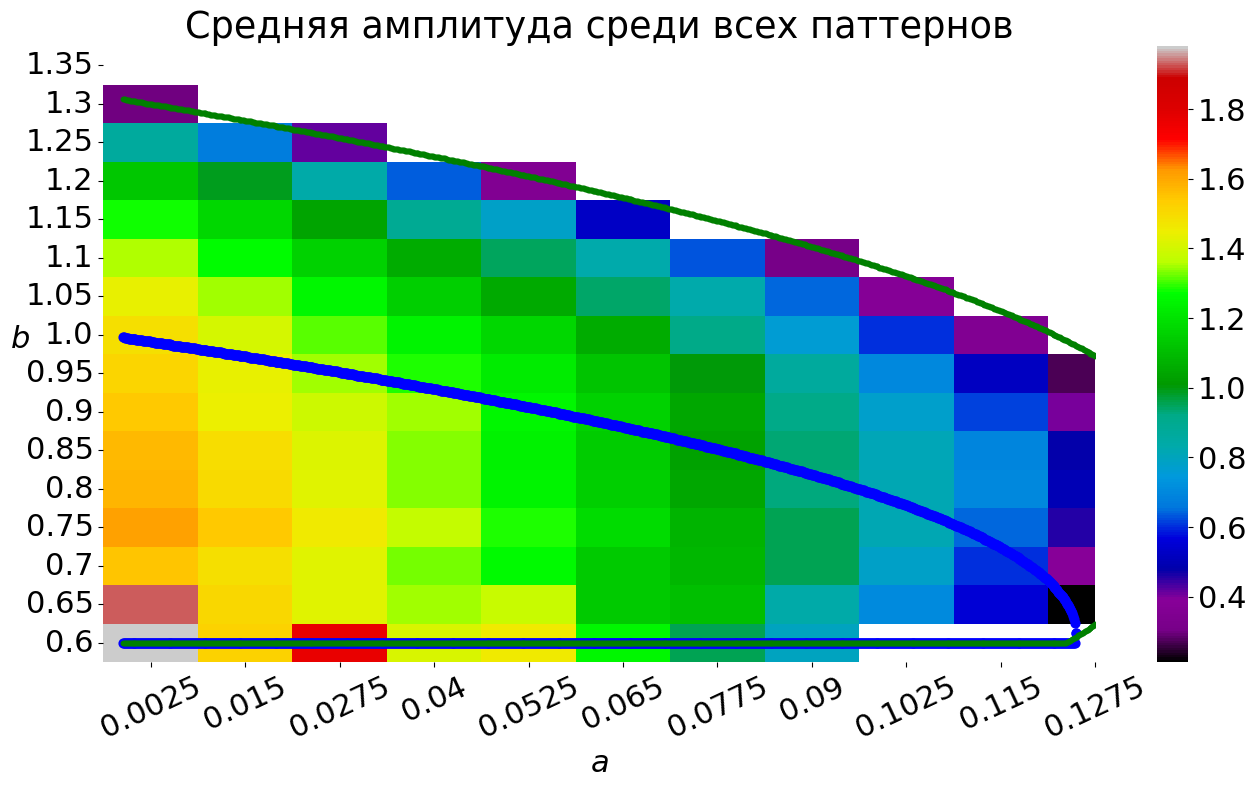

In [183]:
ax = plt.gca()
sns.heatmap(patterns_amp_mean.T[::-1], ax=ax, cmap="nipy_spectral")
print(ax.get_xticks())
print(ax.get_yticks())
ax.set_xticklabels(a_index, rotation=25)
ax.set_yticklabels(list(b_index)[::-1], rotation=0)
ax.set_ylabel("$b$", rotation=0)
ax.set_xlabel("$a$")
ax.set_title("Средняя амплитуда среди всех паттернов")
ax.scatter(hopf_xs * 82.35,15 - (hopf_mins - 0.6)*20 + 0.5, color='b',s=40)
ax.scatter(hopf_xs * 82.35,15 - (hopf_maxs - 0.6)*20 + 0.5, color='b',s=40)
ax.scatter(turing_xs * 82.35,15 - (turing_mins - 0.6)*20 + 0.5, color='g',s=10)
ax.scatter(turing_xs * 82.35,15 - (turing_maxs - 0.6)*20 + 0.5, color='g',s=10)

ax.set_xlim(0,10.5)

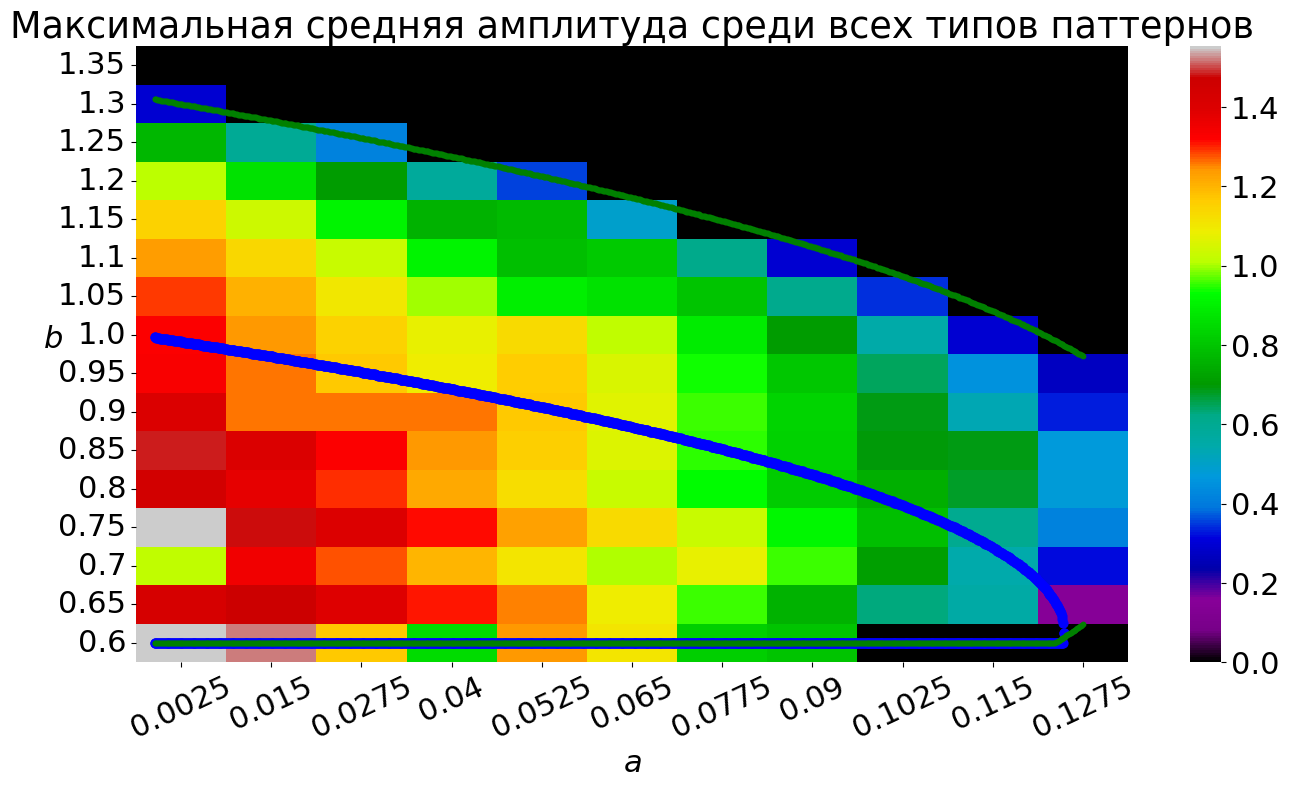

In [188]:
ax = plt.gca()
sns.heatmap(patterns_amp_max.T[::-1], ax=ax,cmap='nipy_spectral')
ax.set_xticklabels(a_index, rotation=25)
ax.set_yticklabels(list(b_index)[::-1], rotation=0)
ax.set_ylabel('$b$', rotation=0)
ax.set_xlabel('$a$')
ax.set_title("Максимальная средняя амплитуда среди всех типов паттернов")
ax.scatter(hopf_xs * 82.35,15 - (hopf_mins - 0.6)*20 + 0.5, color='b',s=40)
ax.scatter(hopf_xs * 82.35,15 - (hopf_maxs - 0.6)*20 + 0.5, color='b',s=40)
ax.scatter(turing_xs * 82.35,15 - (turing_mins - 0.6)*20 + 0.5, color='g',s=10)
ax.scatter(turing_xs * 82.35,15 - (turing_maxs - 0.6)*20 + 0.5, color='g',s=10)

/tmp/ipykernel_12663/1842898249.py:2: RuntimeWarning: invalid value encountered in true_divide
  sns.heatmap(patterns_amp_delta.T[::-1] / patterns_amp_max.T[::-1], ax=ax,cmap='nipy_spectral')


Text(0.5, 1.0, 'Максимум относительной дельты амплитуд среди всех типов паттернов')

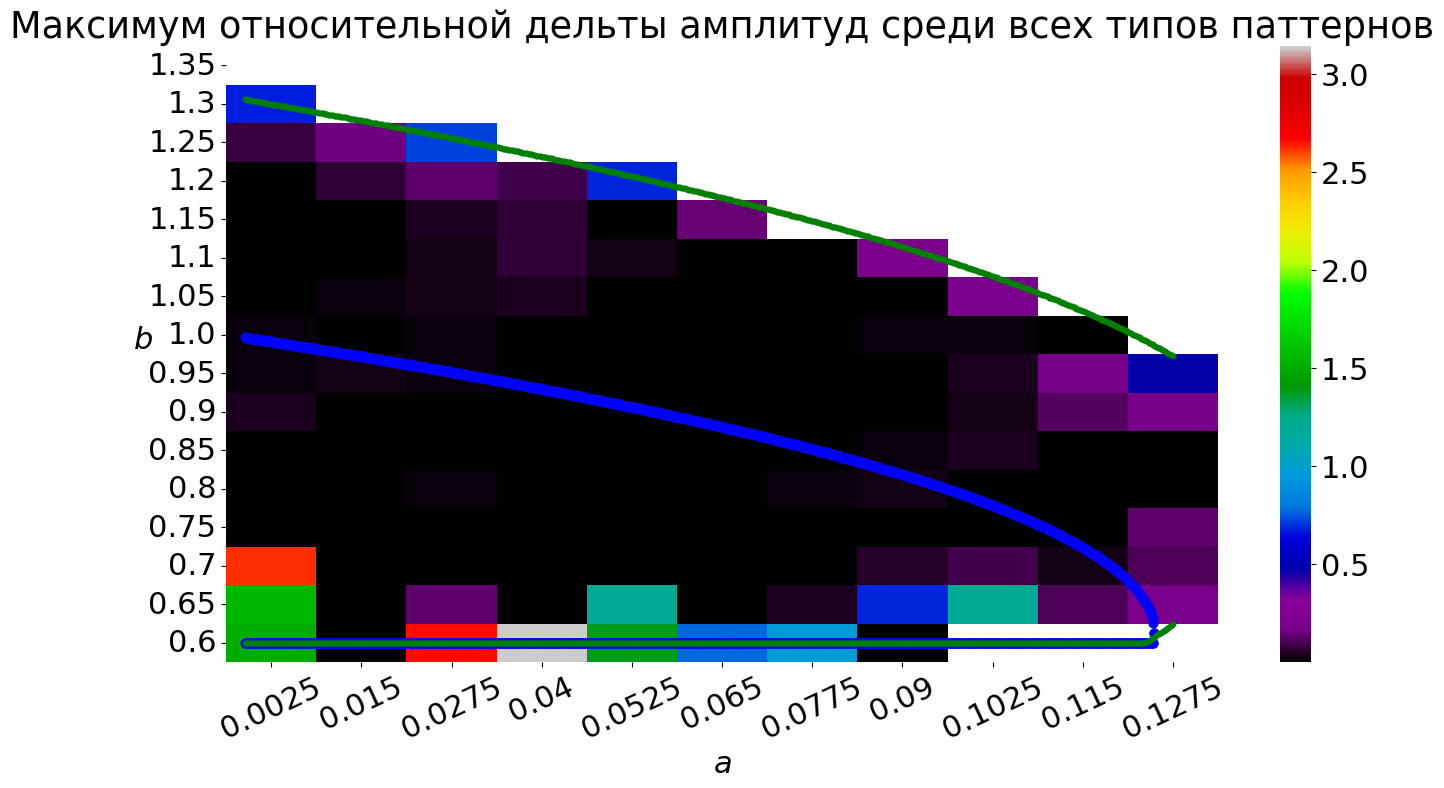

In [192]:
ax = plt.gca()
sns.heatmap(patterns_amp_delta.T[::-1] / patterns_amp_max.T[::-1], ax=ax,cmap='nipy_spectral')
ax.set_xticklabels(a_index, rotation=25)
ax.set_yticklabels(list(b_index)[::-1], rotation=0)
ax.set_ylabel('$b$', rotation=0)
ax.set_xlabel('$a$')
ax.scatter(hopf_xs * 82.35,15 - (hopf_mins - 0.6)*20 + 0.5, color='b',s=40)
ax.scatter(hopf_xs * 82.35,15 - (hopf_maxs - 0.6)*20 + 0.5, color='b',s=40)
ax.scatter(turing_xs * 82.35,15 - (turing_mins - 0.6)*20 + 0.5, color='g',s=10)
ax.scatter(turing_xs * 82.35,15 - (turing_maxs - 0.6)*20 + 0.5, color='g',s=10)
ax.set_title("Максимум относительной дельты амплитуд среди всех типов паттернов")


Text(0.5, 1.0, 'Максимальная дельта амплитуд среди всех типов паттернов')

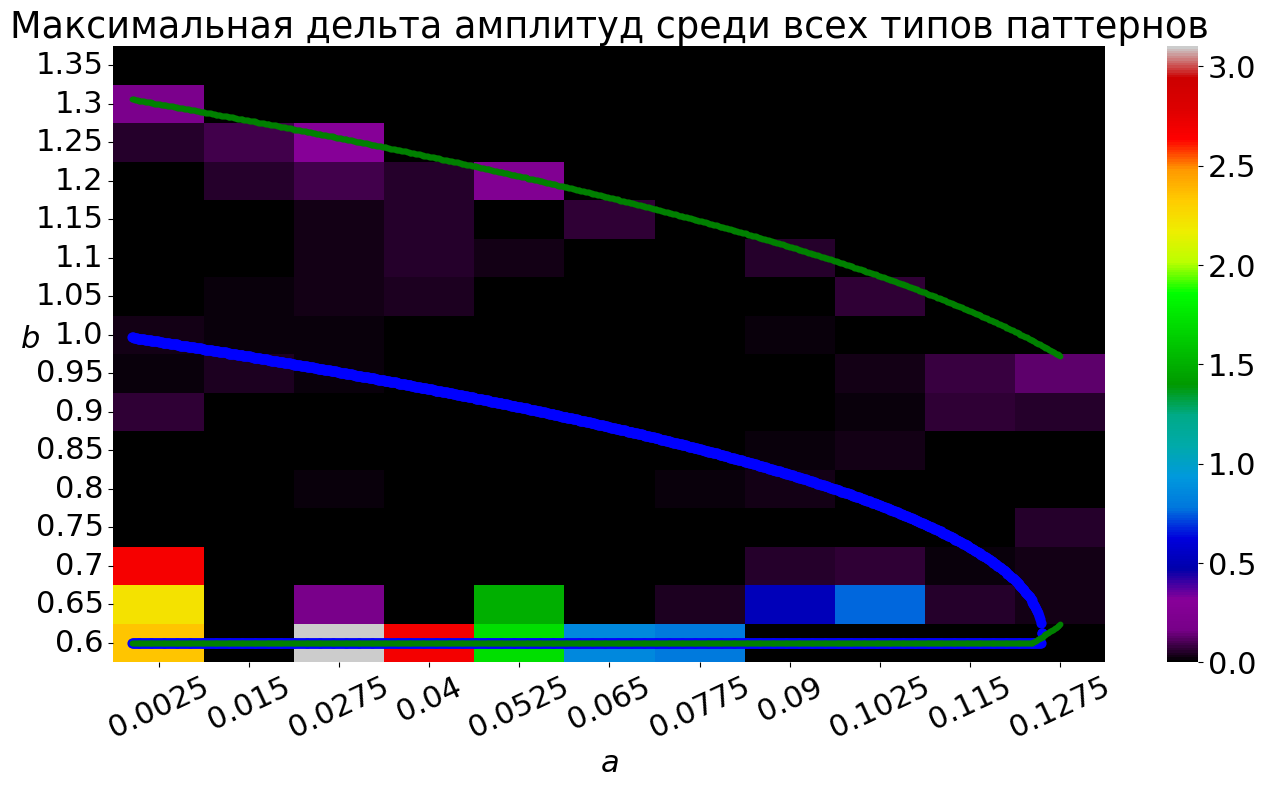

In [193]:
ax = plt.gca()
sns.heatmap(patterns_amp_delta.T[::-1], ax=ax,cmap='nipy_spectral')
ax.set_xticklabels(a_index, rotation=25)
ax.set_yticklabels(list(b_index)[::-1], rotation=0)
ax.set_ylabel('$b$', rotation=0)
ax.set_xlabel('$a$')
ax.scatter(hopf_xs * 82.35,15 - (hopf_mins - 0.6)*20 + 0.5, color='b',s=40)
ax.scatter(hopf_xs * 82.35,15 - (hopf_maxs - 0.6)*20 + 0.5, color='b',s=40)
ax.scatter(turing_xs * 82.35,15 - (turing_mins - 0.6)*20 + 0.5, color='g',s=10)
ax.scatter(turing_xs * 82.35,15 - (turing_maxs - 0.6)*20 + 0.5, color='g',s=10)
ax.set_title("Максимальная дельта амплитуд среди всех типов паттернов")

Text(0.5, 1.0, 'Доля процессов сформировавших паттерн')

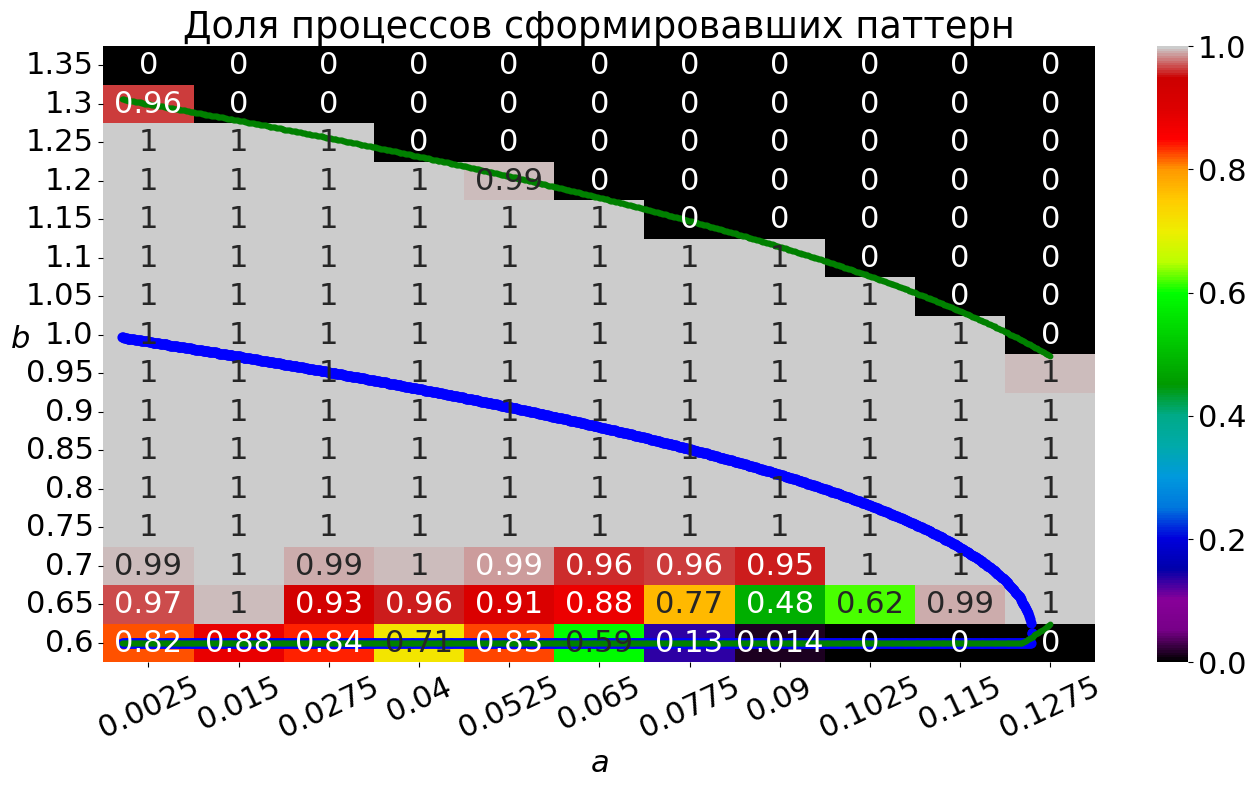

In [194]:
ax = plt.gca()
sns.heatmap(patterns_count.T[::-1]/500, ax=ax,cmap='nipy_spectral', annot=True)
ax.set_xticklabels(a_index, rotation=25)
ax.set_yticklabels(list(b_index)[::-1], rotation=0)
ax.set_ylabel('$b$', rotation=0)
ax.set_xlabel('$a$')
ax.scatter(hopf_xs * 82.35,15 - (hopf_mins - 0.6)*20 + 0.5, color='b',s=40)
ax.scatter(hopf_xs * 82.35,15 - (hopf_maxs - 0.6)*20 + 0.5, color='b',s=40)
ax.scatter(turing_xs * 82.35,15 - (turing_mins - 0.6)*20 + 0.5, color='g',s=10)
ax.scatter(turing_xs * 82.35,15 - (turing_maxs - 0.6)*20 + 0.5, color='g',s=10)

ax.set_title("Доля процессов сформировавших паттерн")

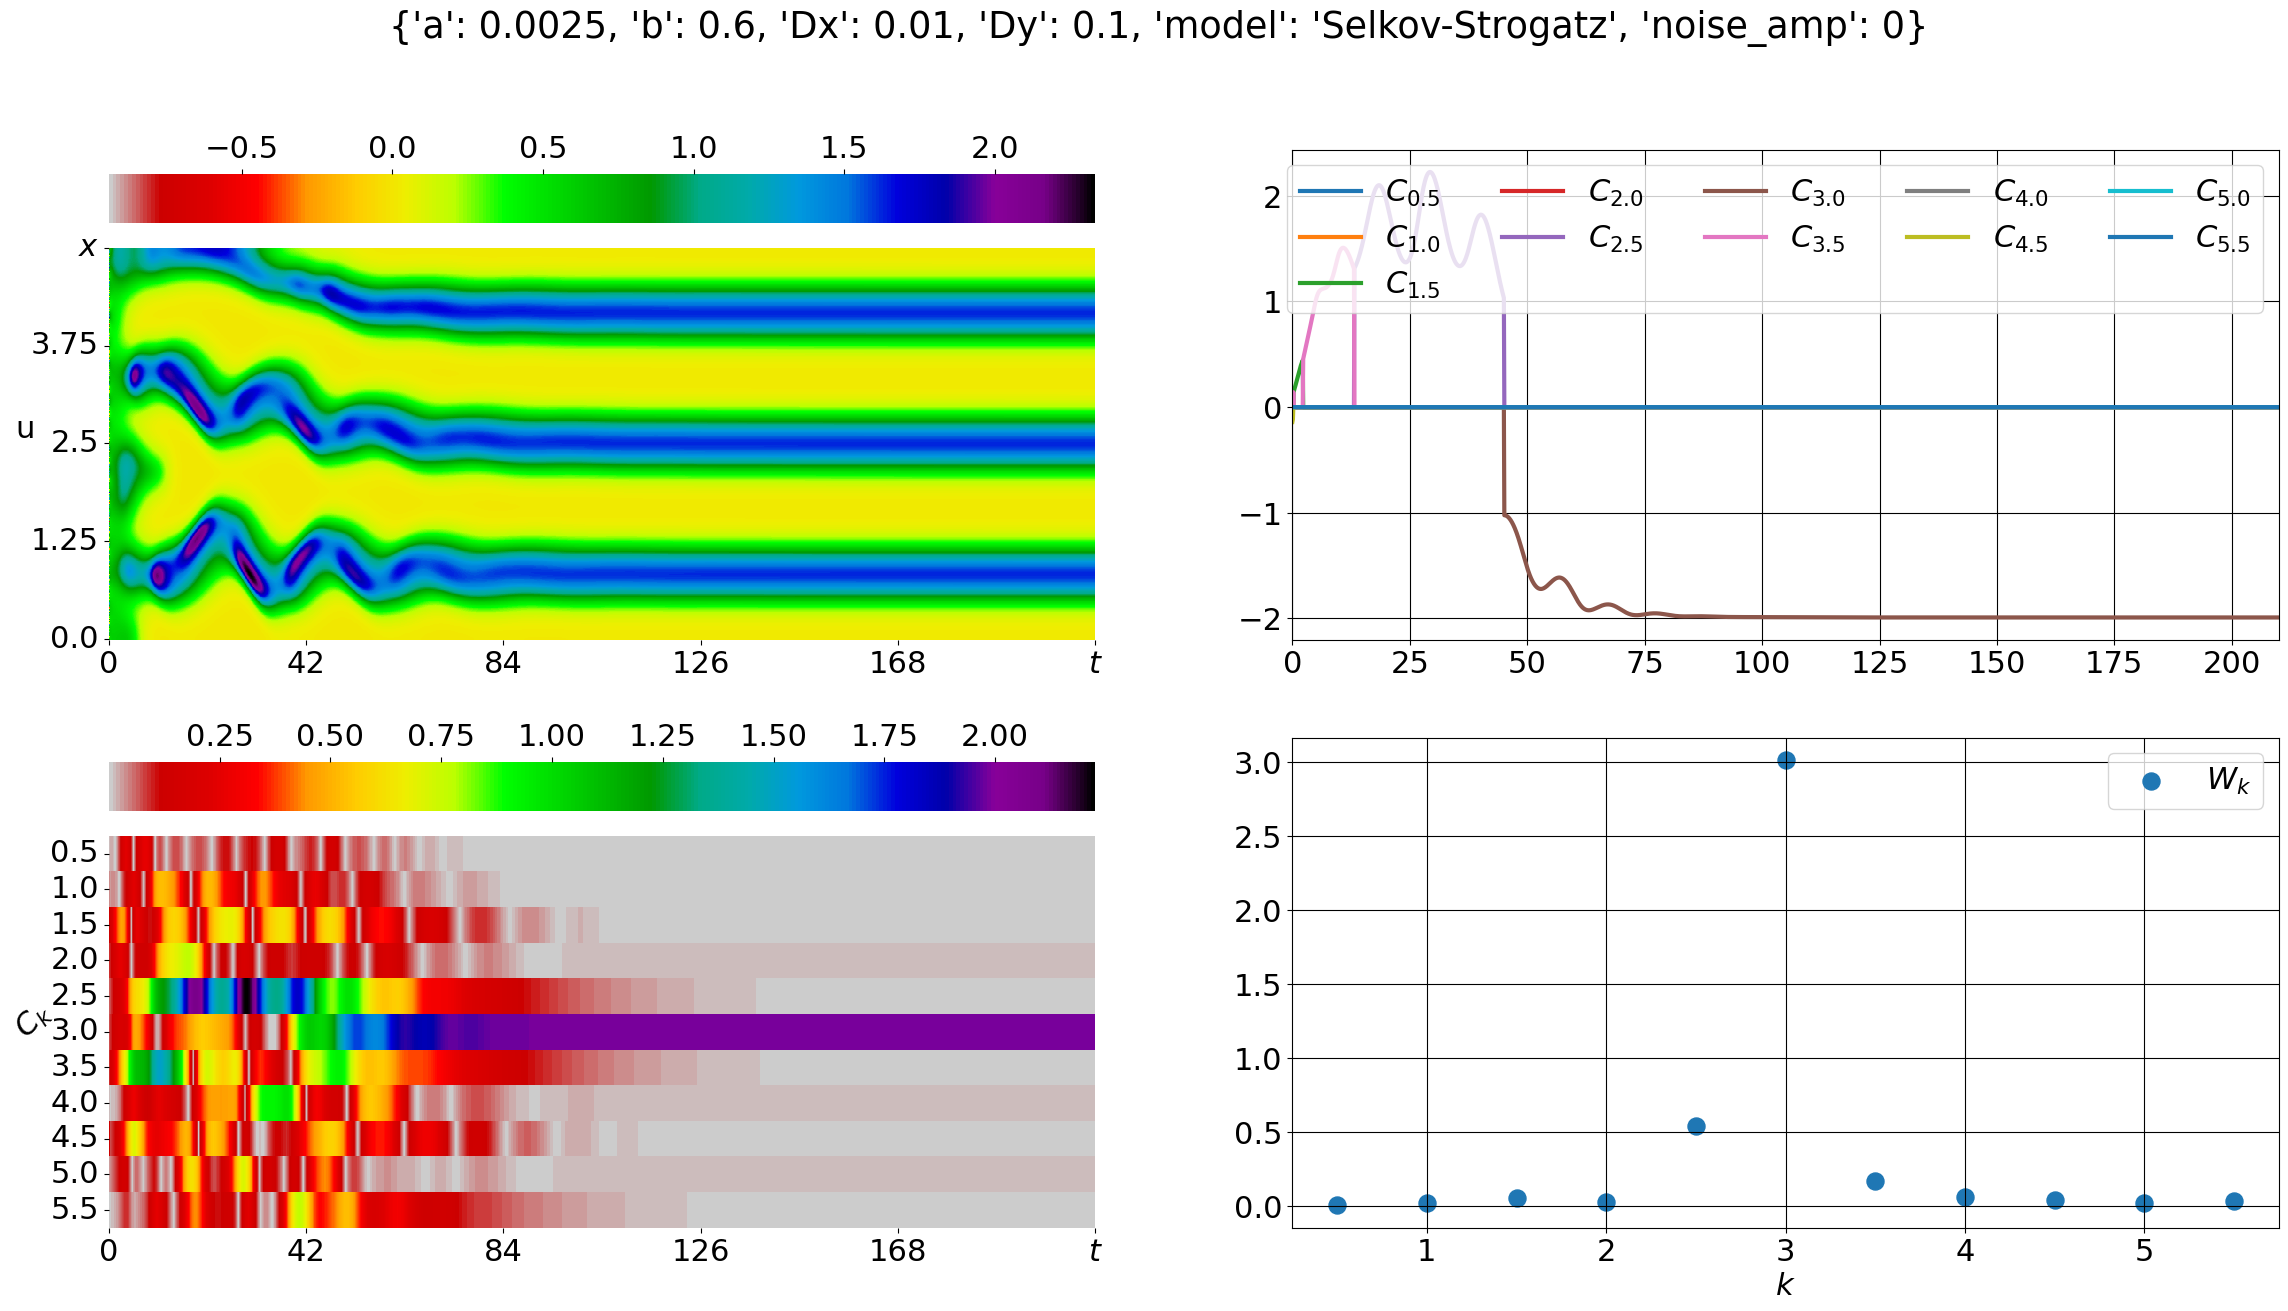

In [196]:
exxx = Experiment().fill_from(params_to_exps[(0.0025, 0.6)][100].path_to_file, load_timelines=True)
draw_quadreega(exxx, FOURIER_KS[:11], 'u' )

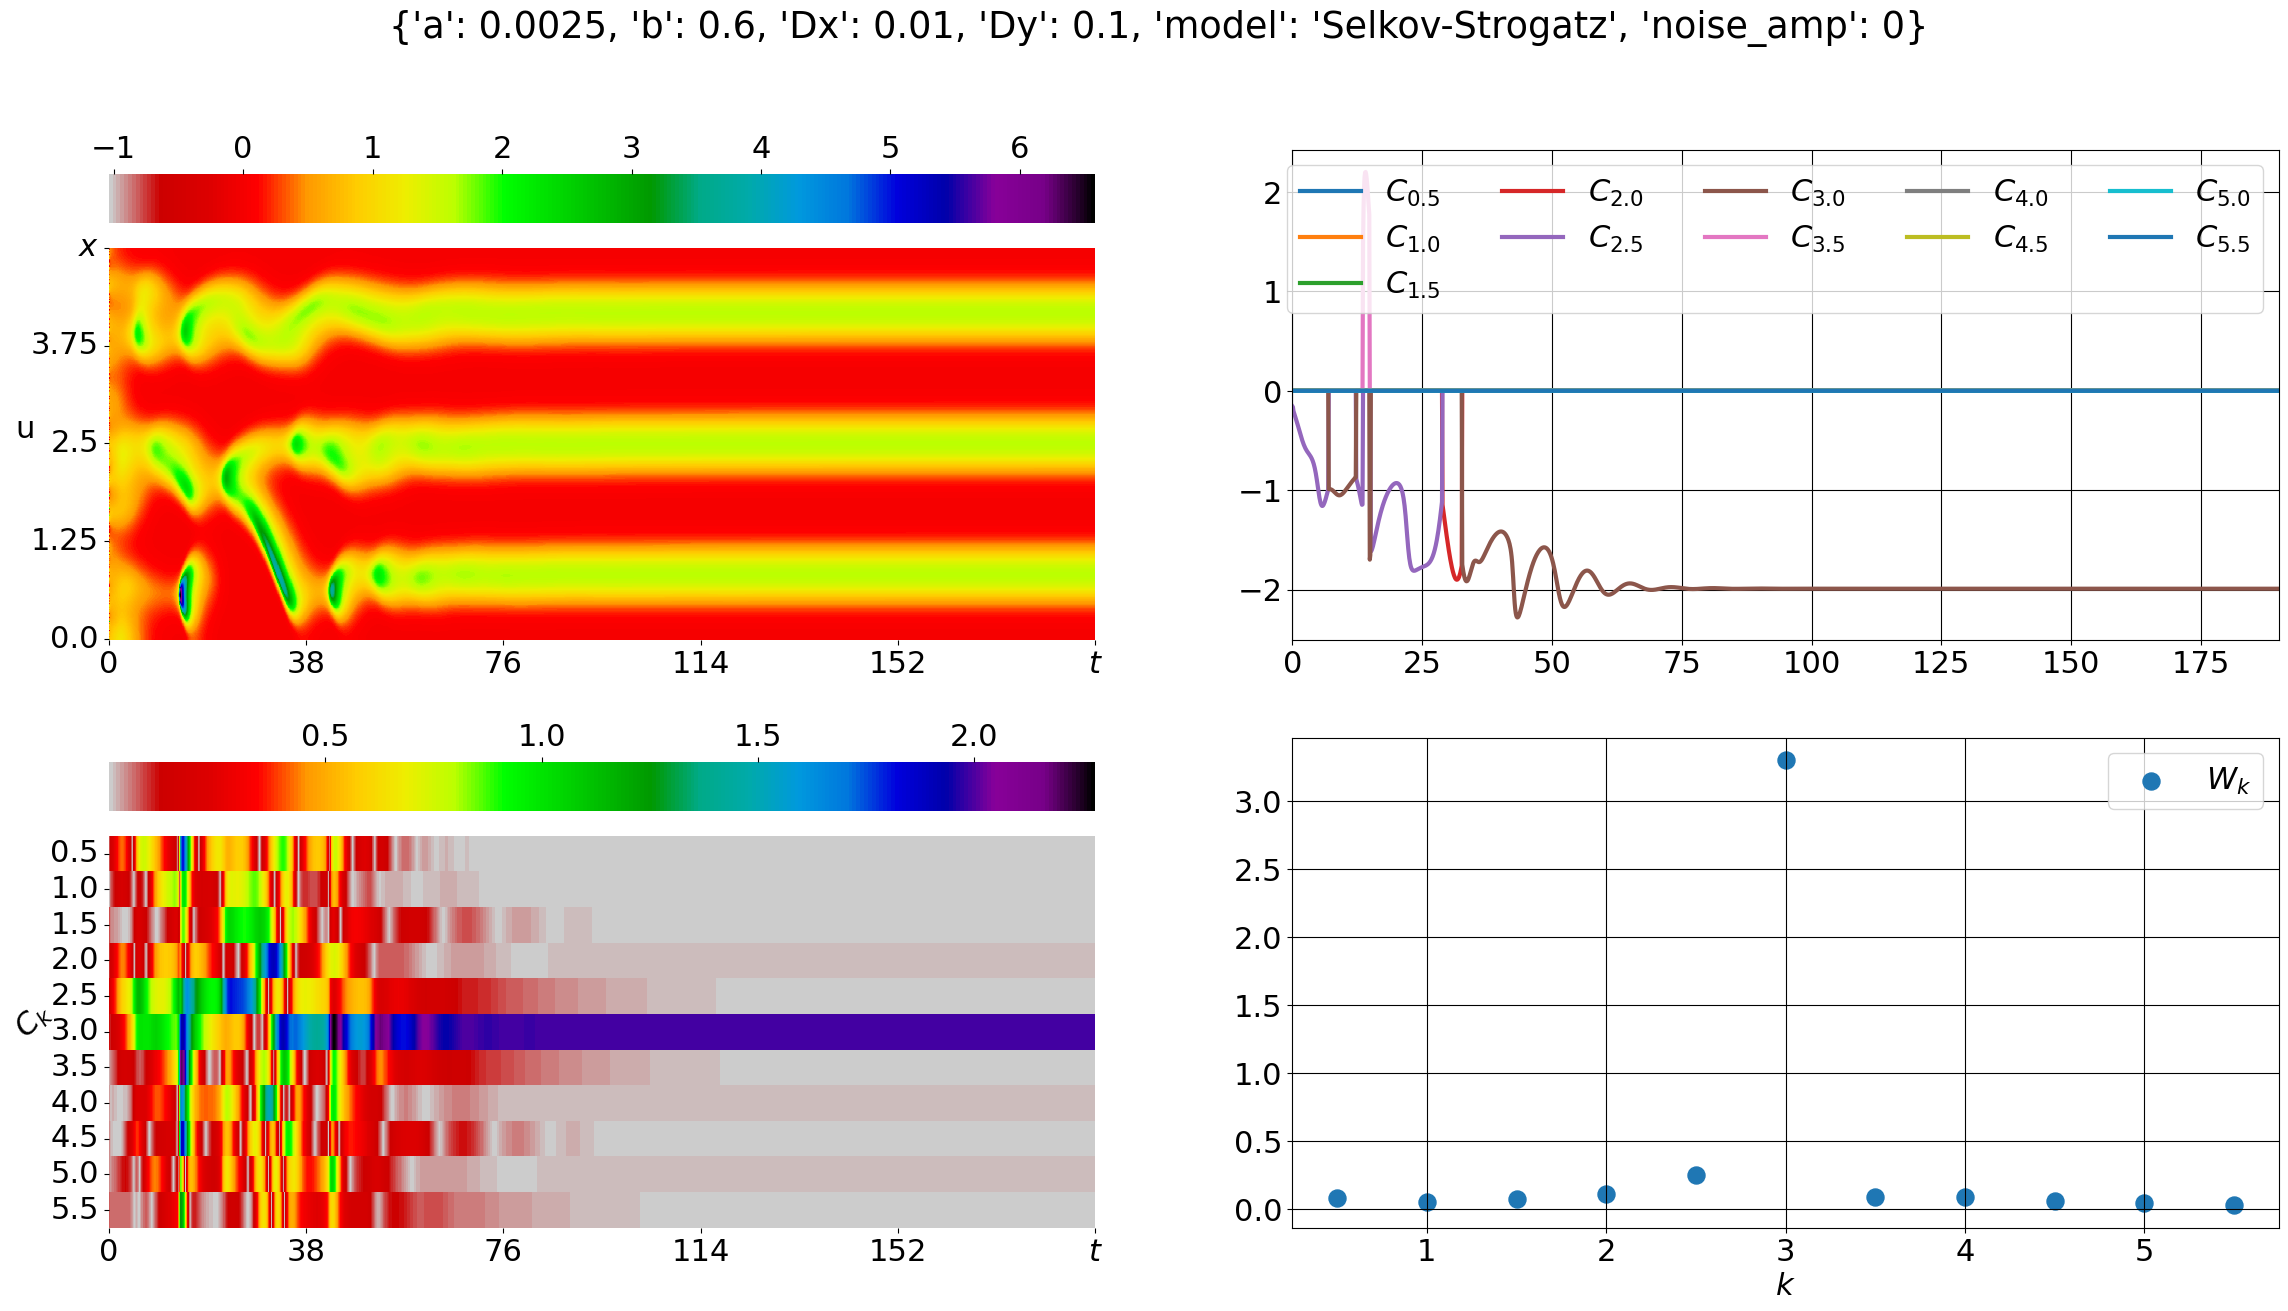

In [41]:
exxx = Experiment().fill_from(params_to_exps[(0.0025, 0.6)][200].path_to_file, load_timelines=True)
draw_quadreega(exxx, FOURIER_KS[:11], 'u', )

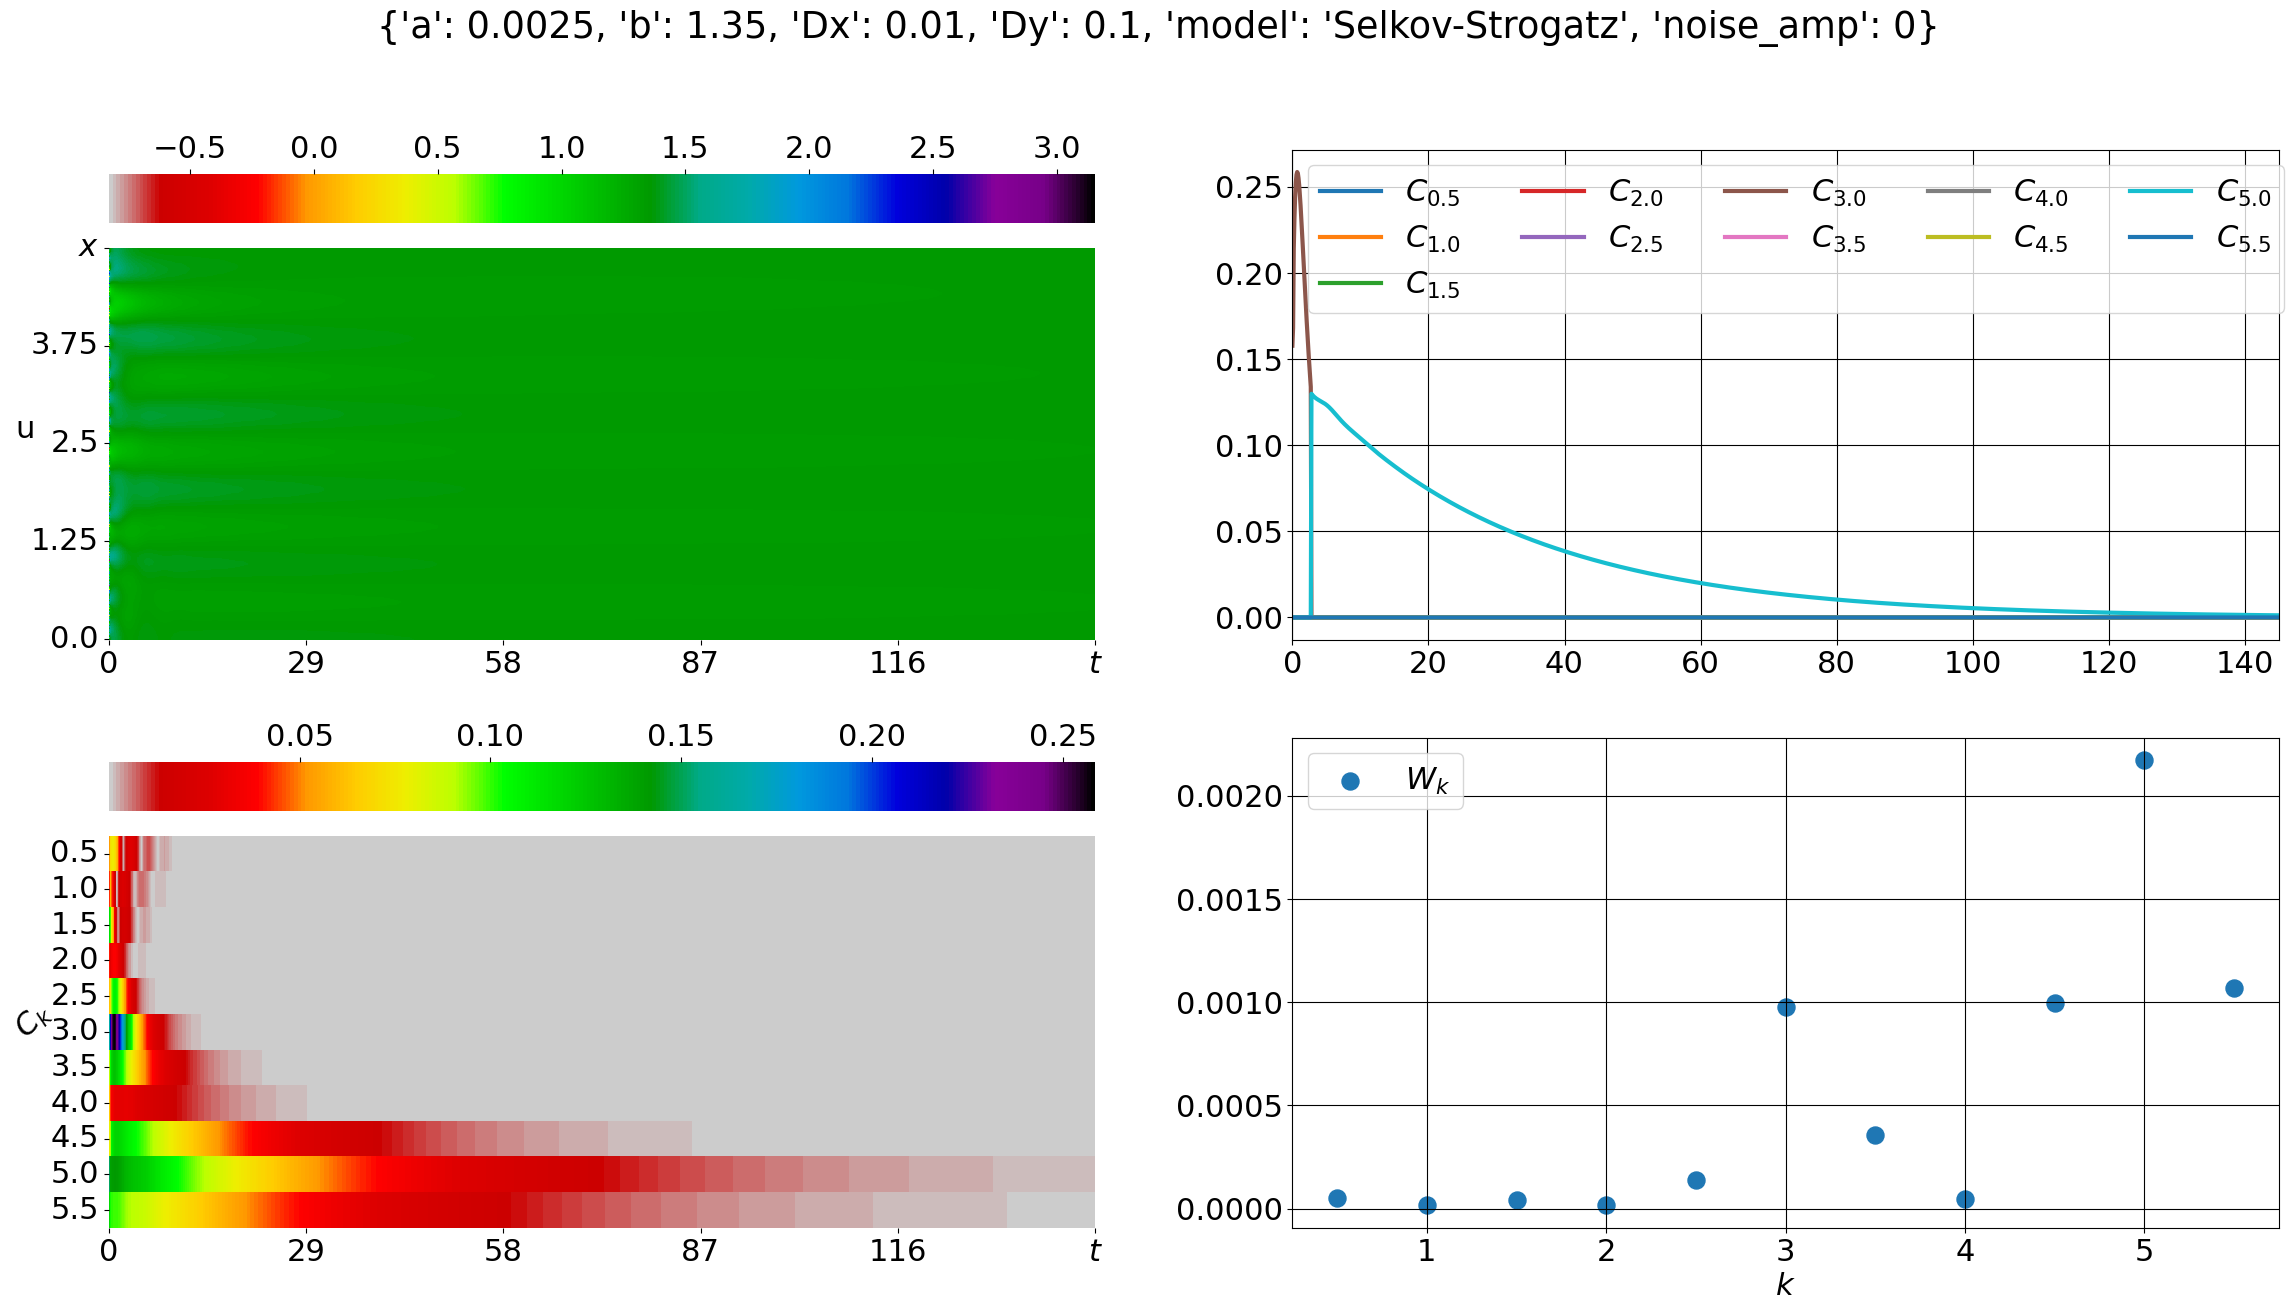

In [201]:
exxx = Experiment().fill_from(params_to_exps[(0.0025, 1.35)][201].path_to_file, load_timelines=True)
draw_quadreega(exxx, FOURIER_KS[:11], 'u', )

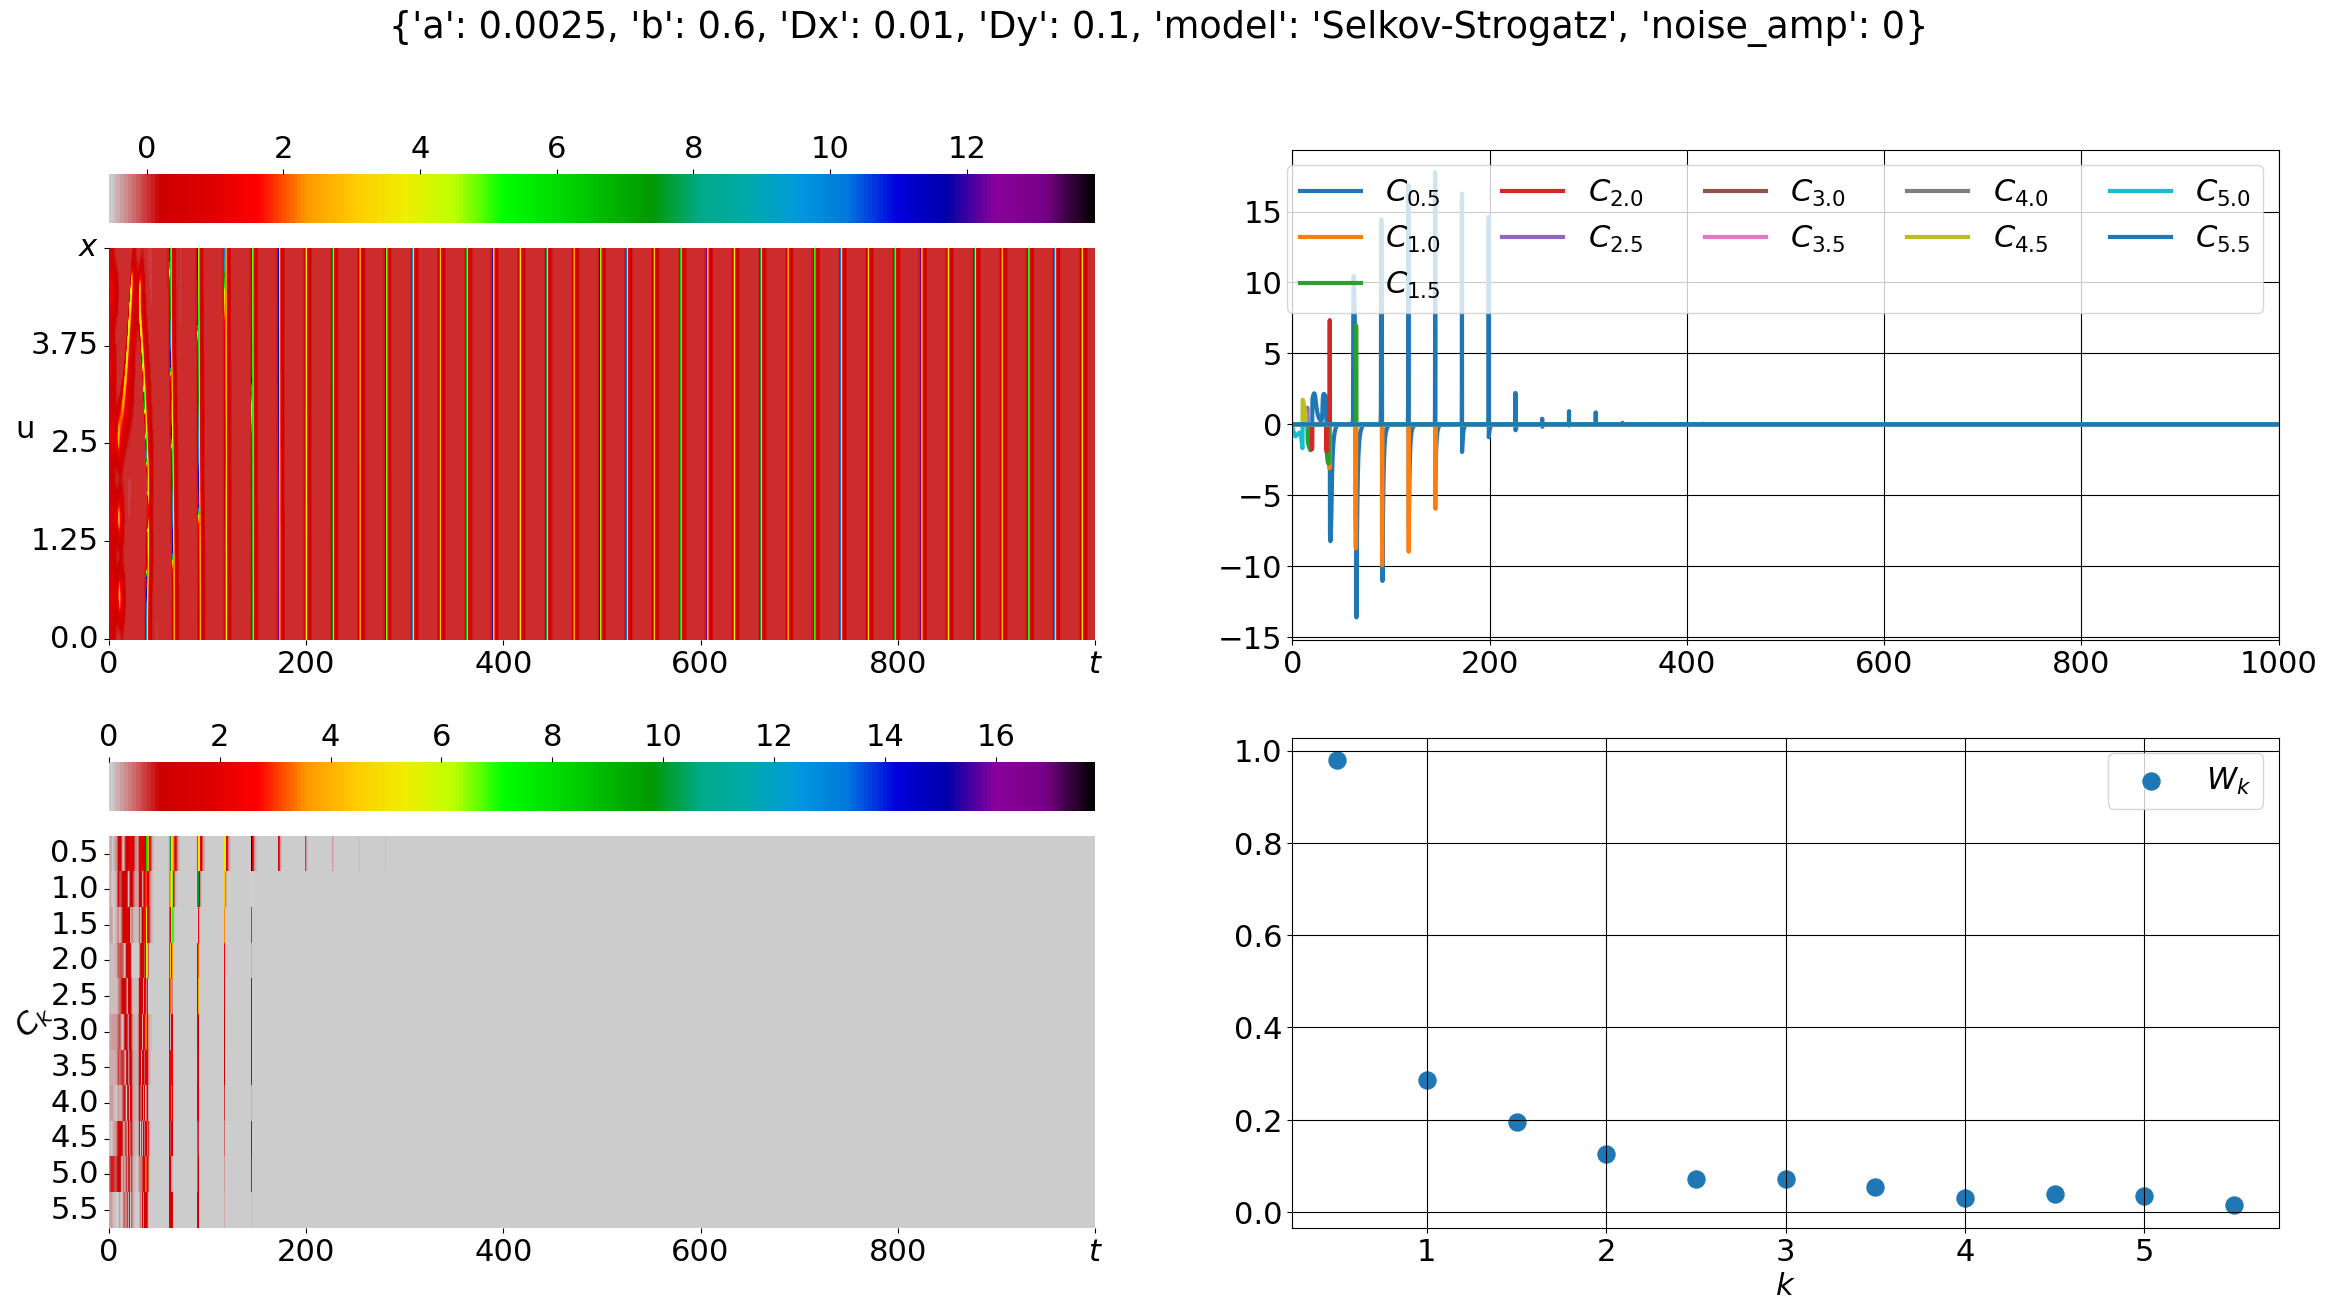

In [47]:
homog_exp = min(params_to_exps[(0.0025, 0.6)], key = lambda e: max(e.end_values['u']) - min(e.end_values['u']))
exxx = Experiment().fill_from(homog_exp.path_to_file, load_timelines=True)
draw_quadreega(exxx, FOURIER_KS[:11], 'u', )

dict_keys([3.0, 3.5, 1.0, 2.0])


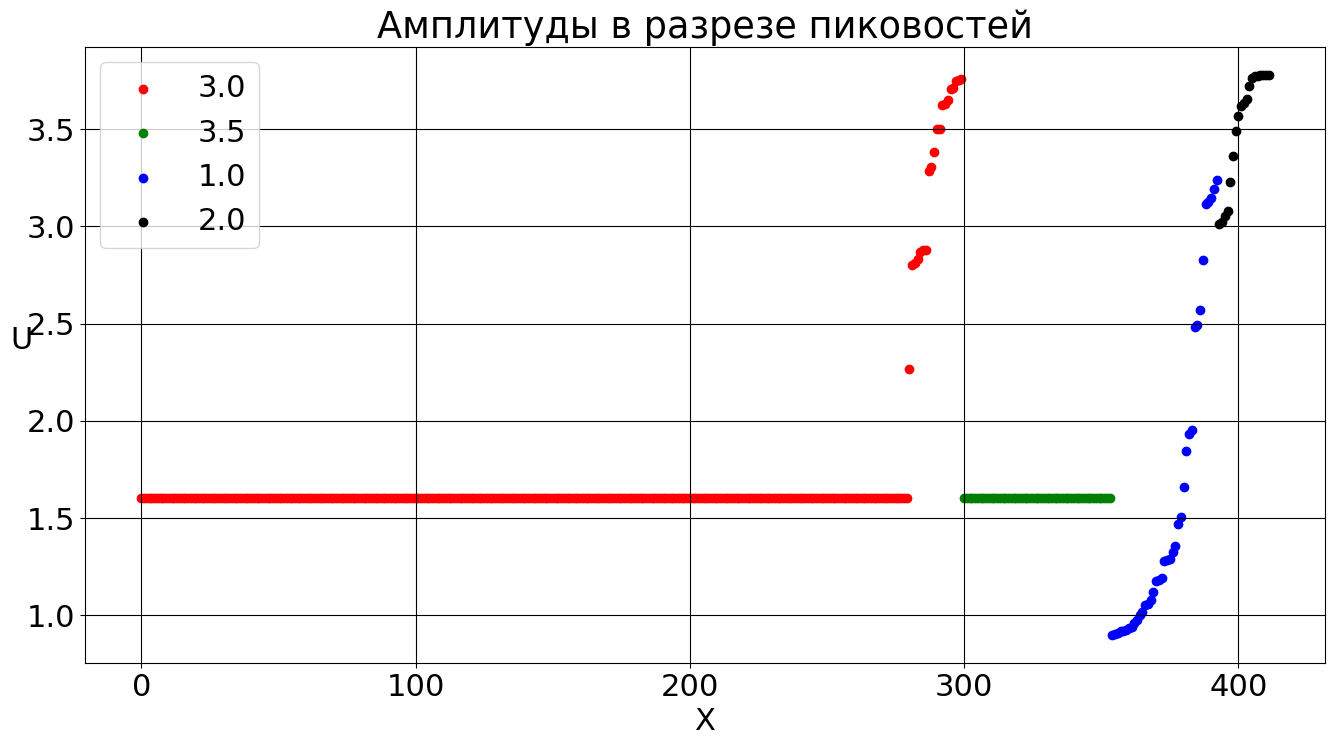

In [262]:
res = defaultdict(list)
res_exps = defaultdict(list)
for exp in params_to_exps[(0.0025, 0.6)]:
    pcks = calc_peaks_by_Fourier(exp,var='u', max_peaks_count=10, min_amplitude=0.1)
    if pcks is None:
        continue
    pcks = pcks.peaks_count
    res[pcks].append(max(exp.end_values['u']) - min(exp.end_values['u']))
    res_exps[pcks].append(exp)
for k in res_exps:
    res_exps[k] = sorted(res_exps[k], key=lambda e: max(e.end_values['u']) - min(e.end_values['u']))
print(res.keys())
ax = plt.gca()
c = ['r','g','b','k']
summ = 0
for i, (k, v) in enumerate(res.items()):

    ax.scatter(range(summ, summ+len(v)), sorted(v), c=c[i], label=f'{k}')
    summ+=len(v)
ax.set_xlabel('X')
ax.set_ylabel('U', rotation=0)
ax.set_title('Амплитуды в разрезе пиковостей')
plt.legend()
plt.show()

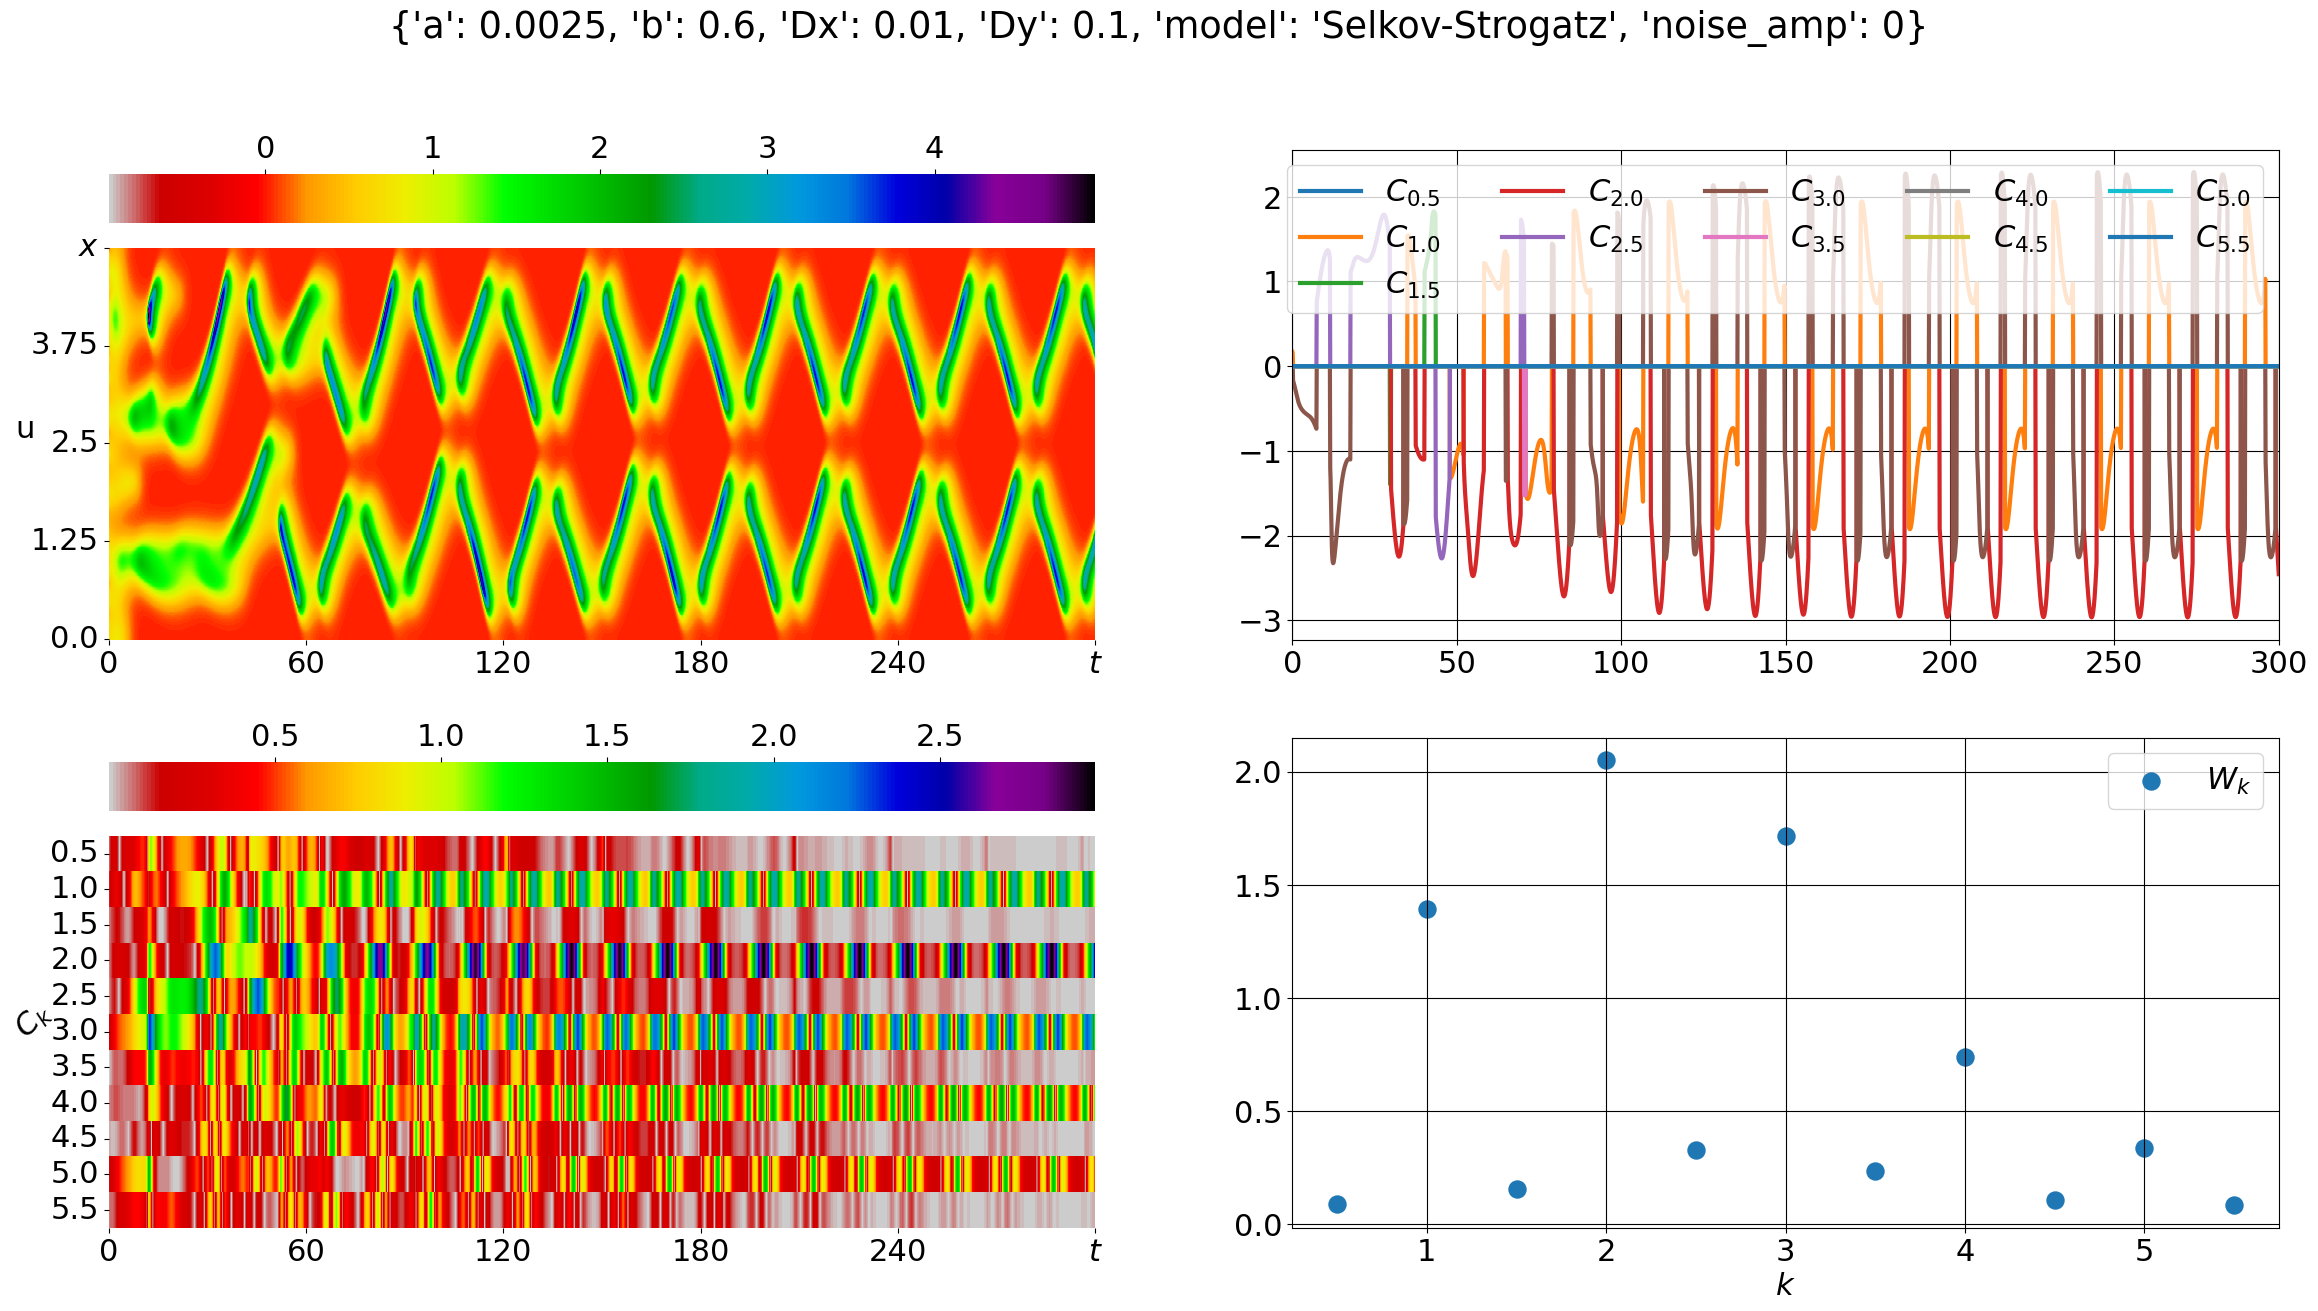

In [263]:
exxx = Experiment().fill_from(res_exps[2.0][0].path_to_file, load_timelines=True)
draw_quadreega(exxx, FOURIER_KS[:11], 'u', right_border_t=300)

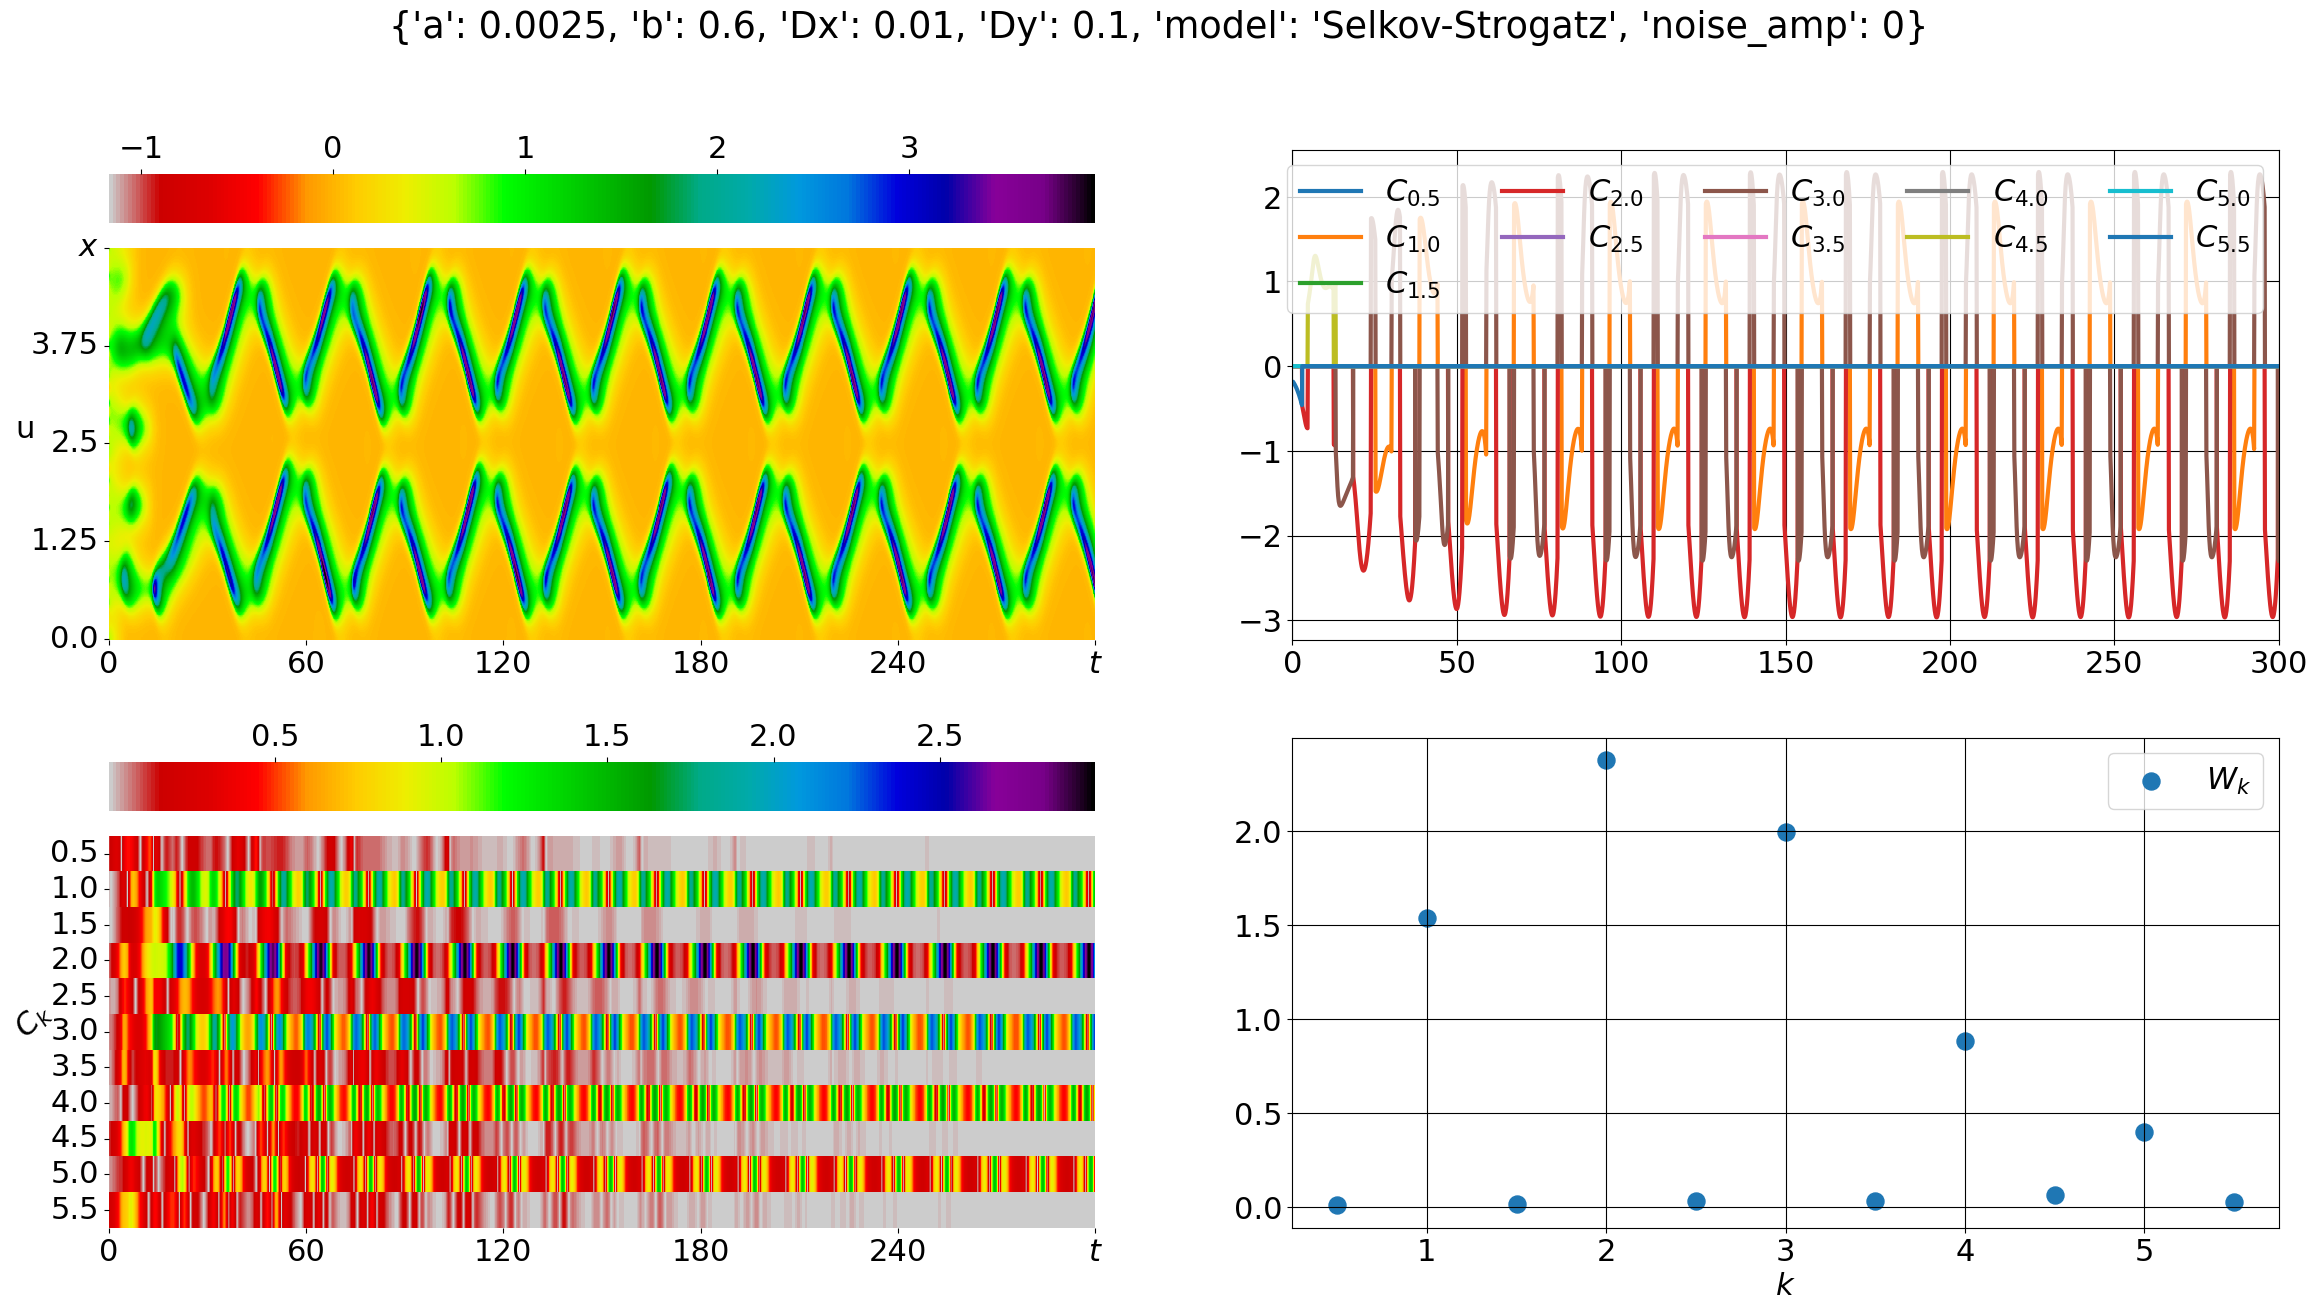

In [264]:
exxx = Experiment().fill_from(res_exps[2.0][-1].path_to_file, load_timelines=True)
draw_quadreega(exxx, FOURIER_KS[:11], 'u', right_border_t=300)

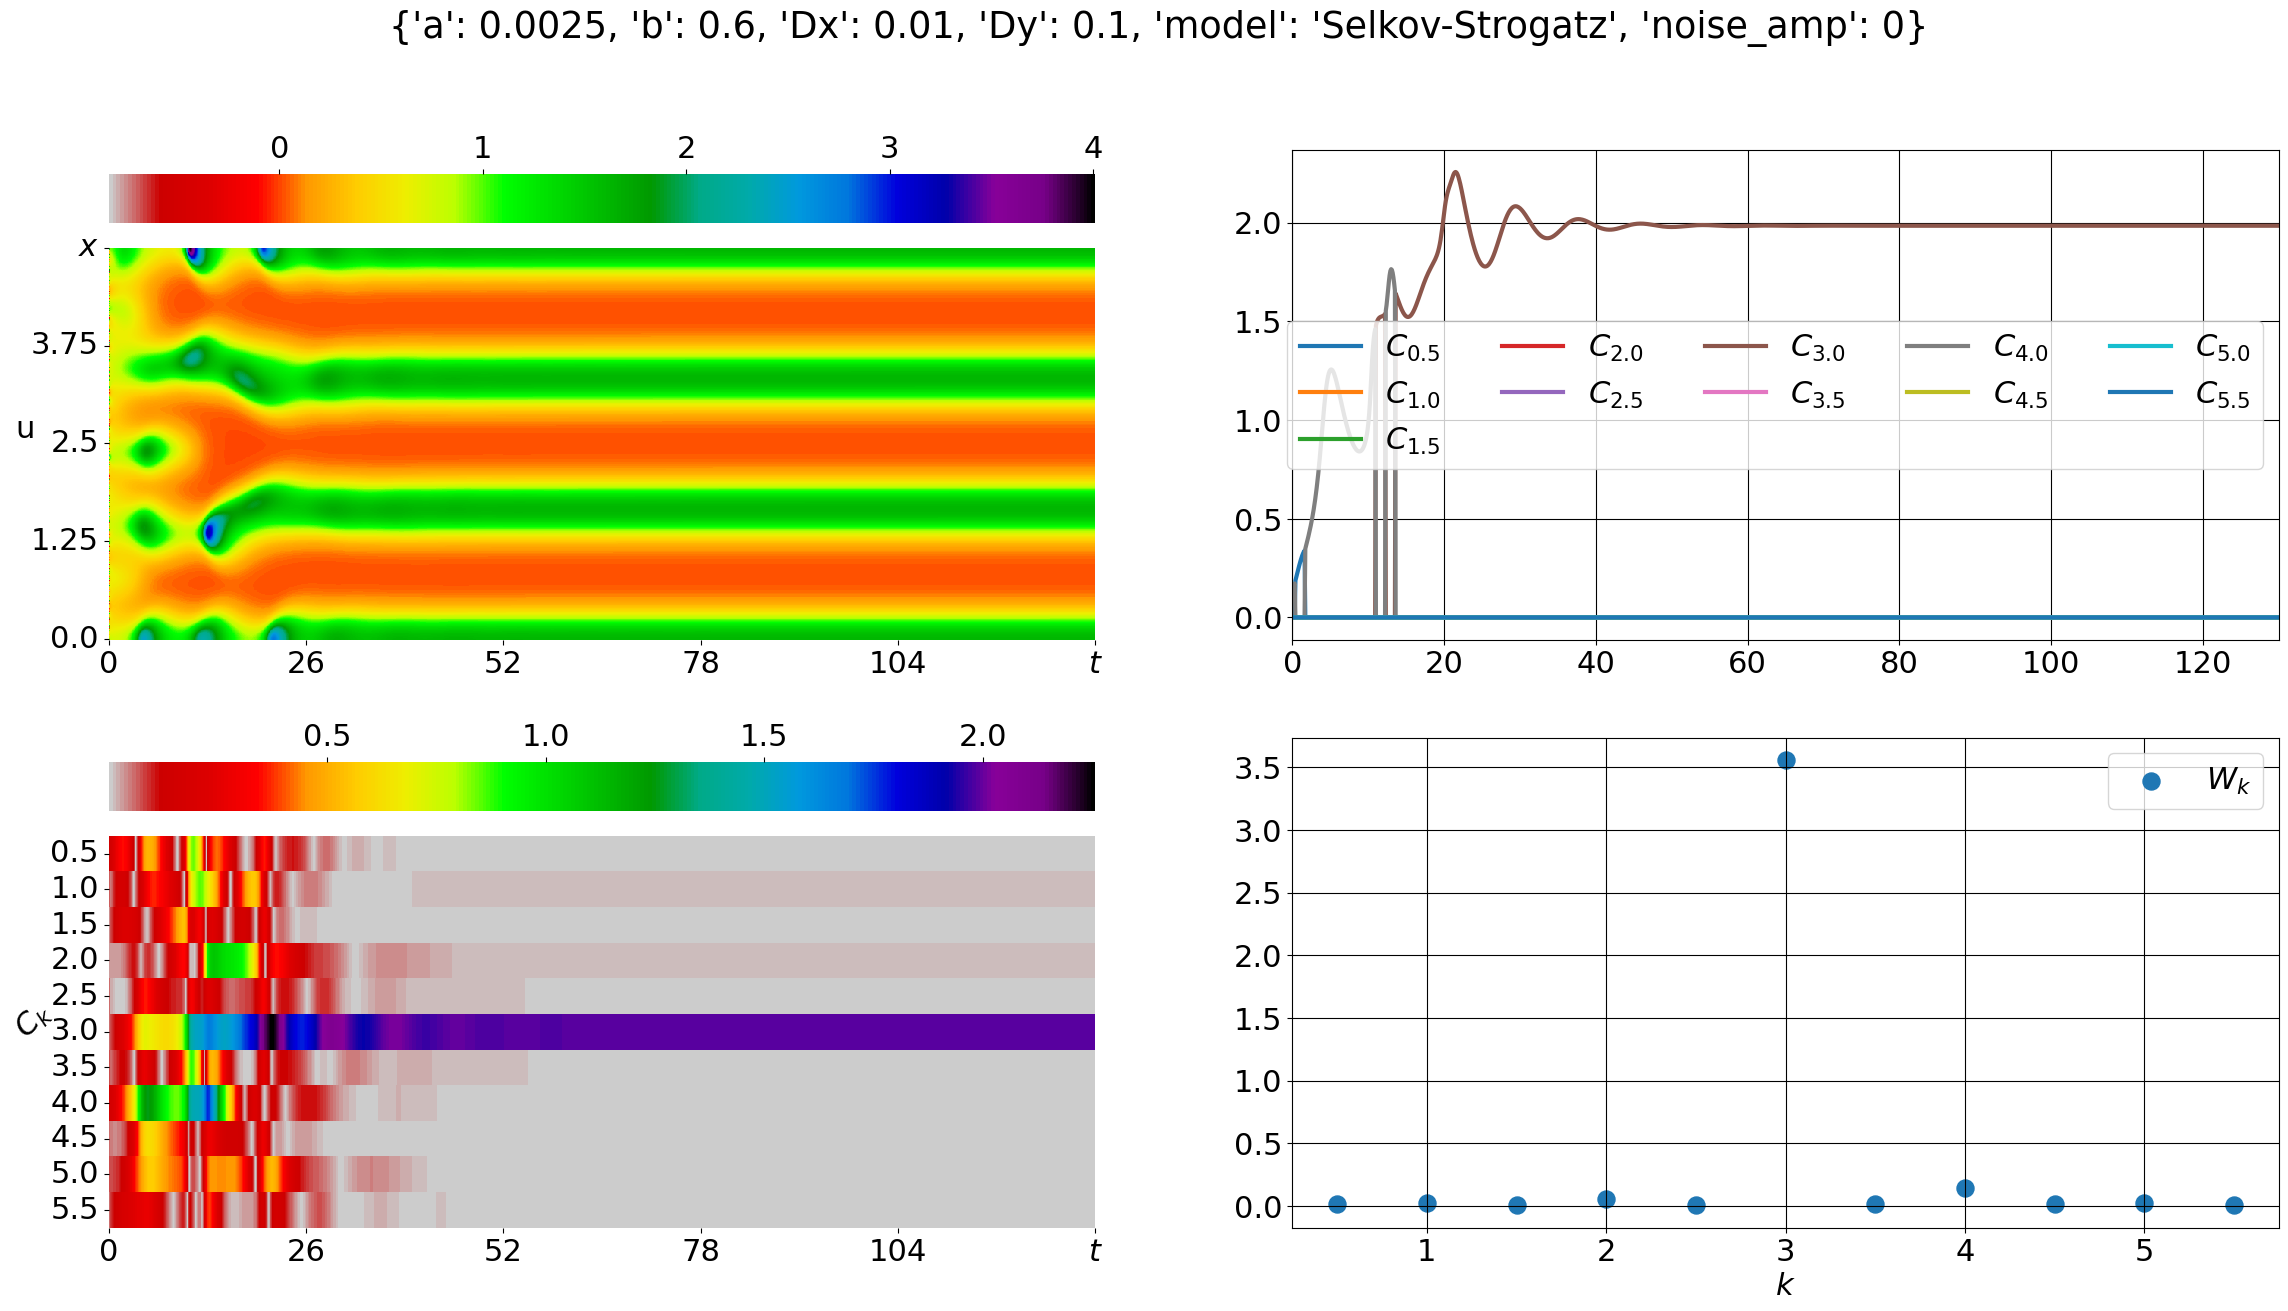

In [251]:
exxx = Experiment().fill_from(res_exps[3.0][0].path_to_file, load_timelines=True)
draw_quadreega(exxx, FOURIER_KS[:11], 'u', right_border_t=300)

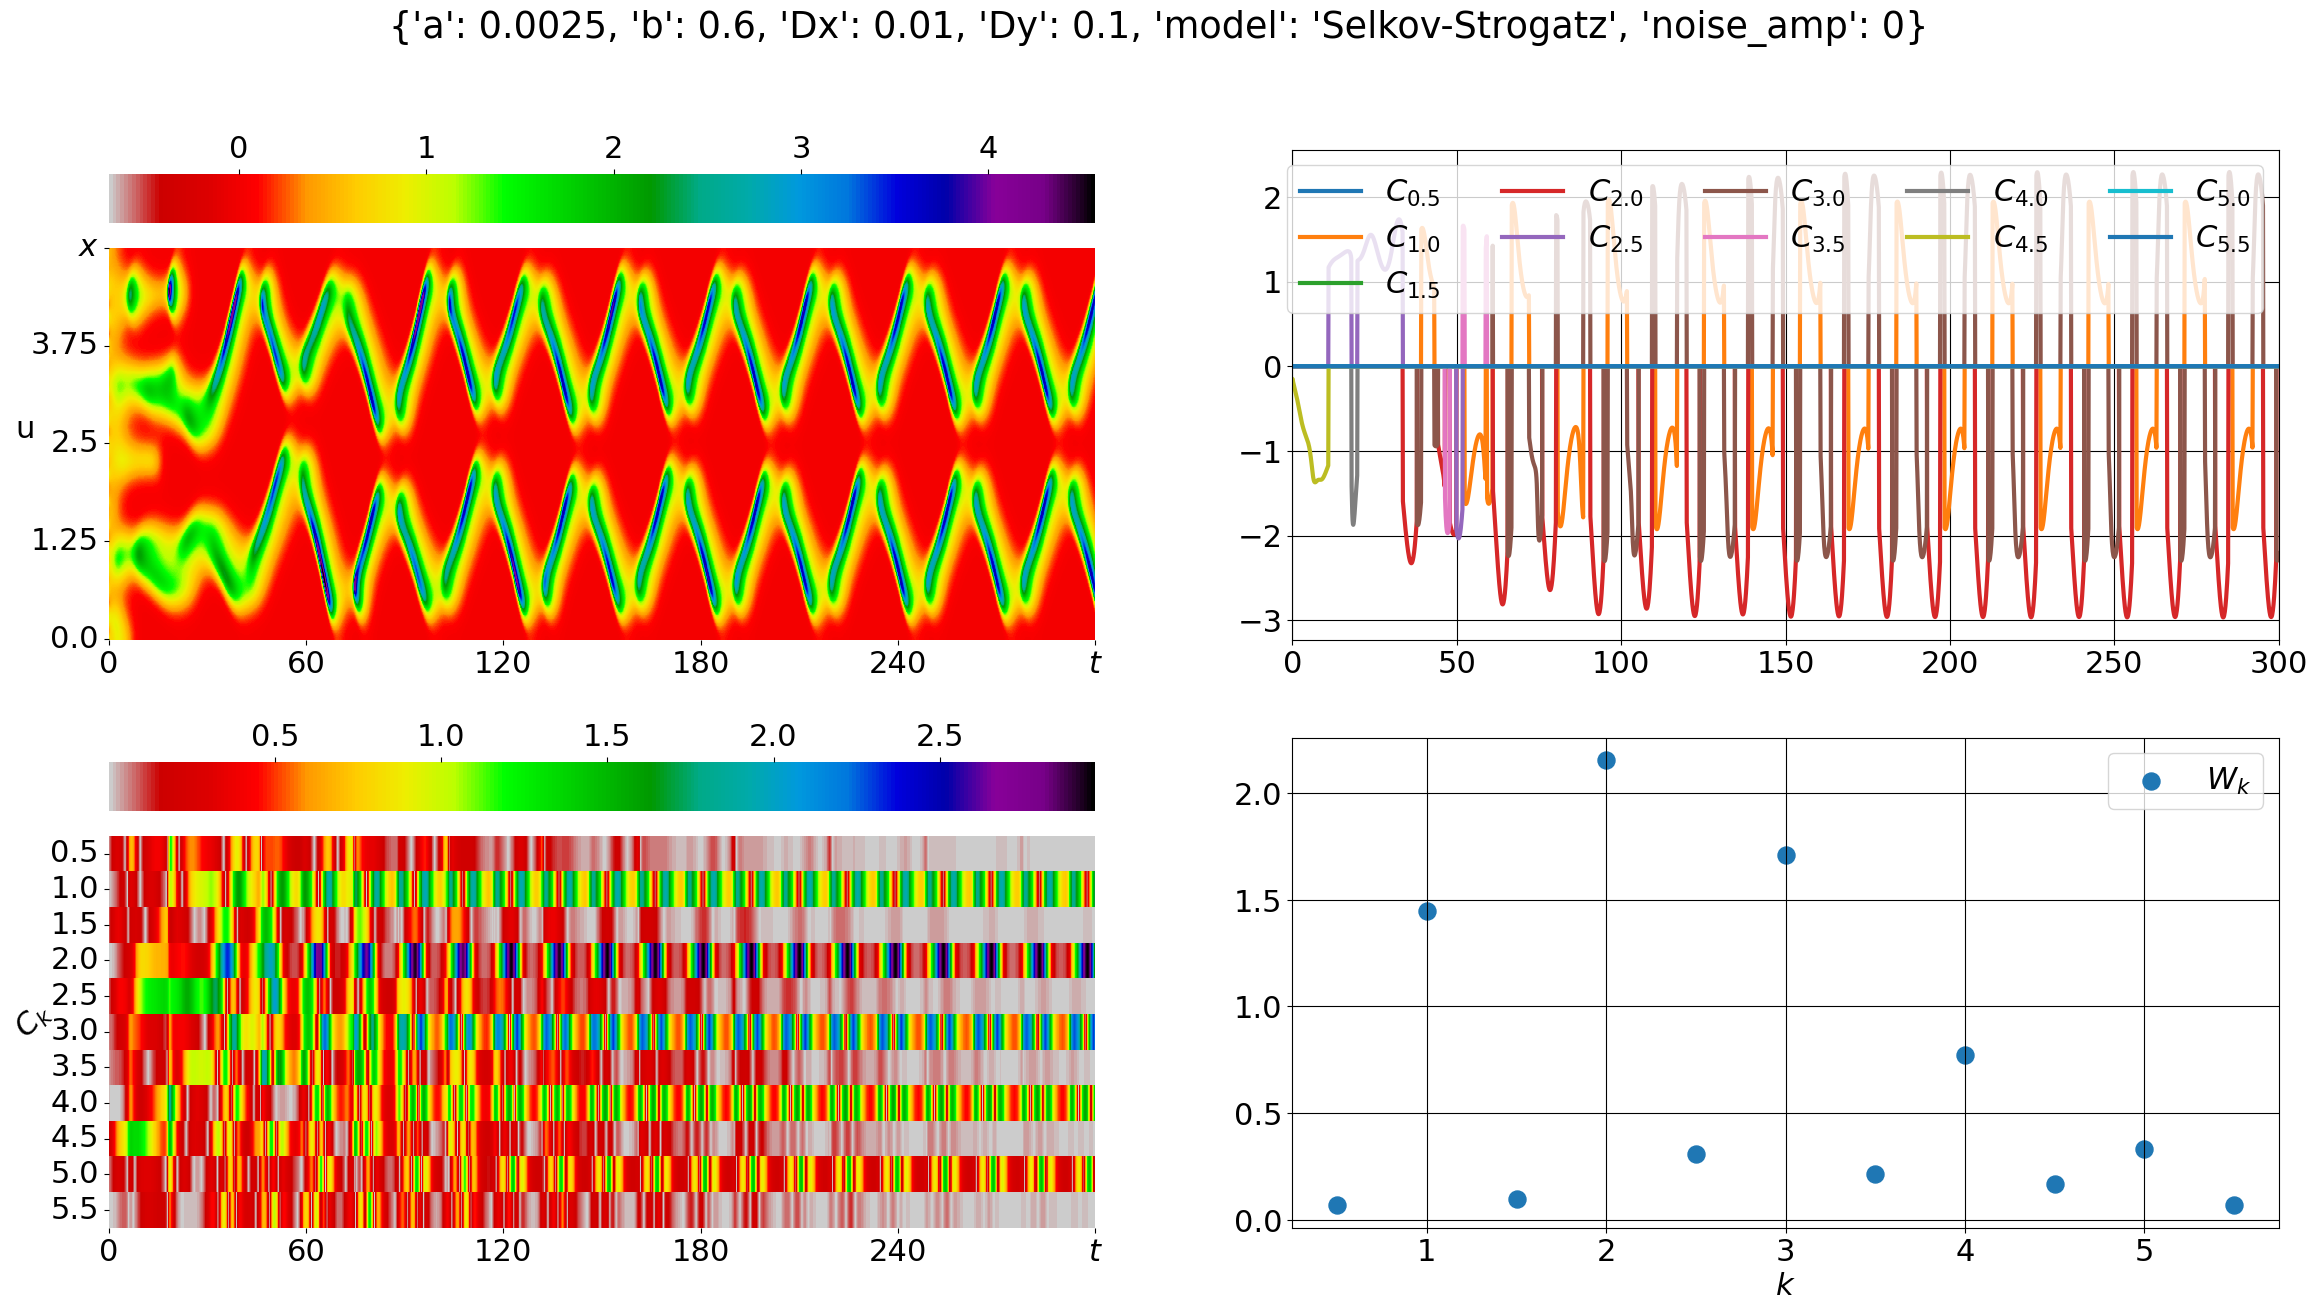

In [252]:
exxx = Experiment().fill_from(res_exps[3.0][-1].path_to_file, load_timelines=True)
draw_quadreega(exxx, FOURIER_KS[:11], 'u', right_border_t=300)

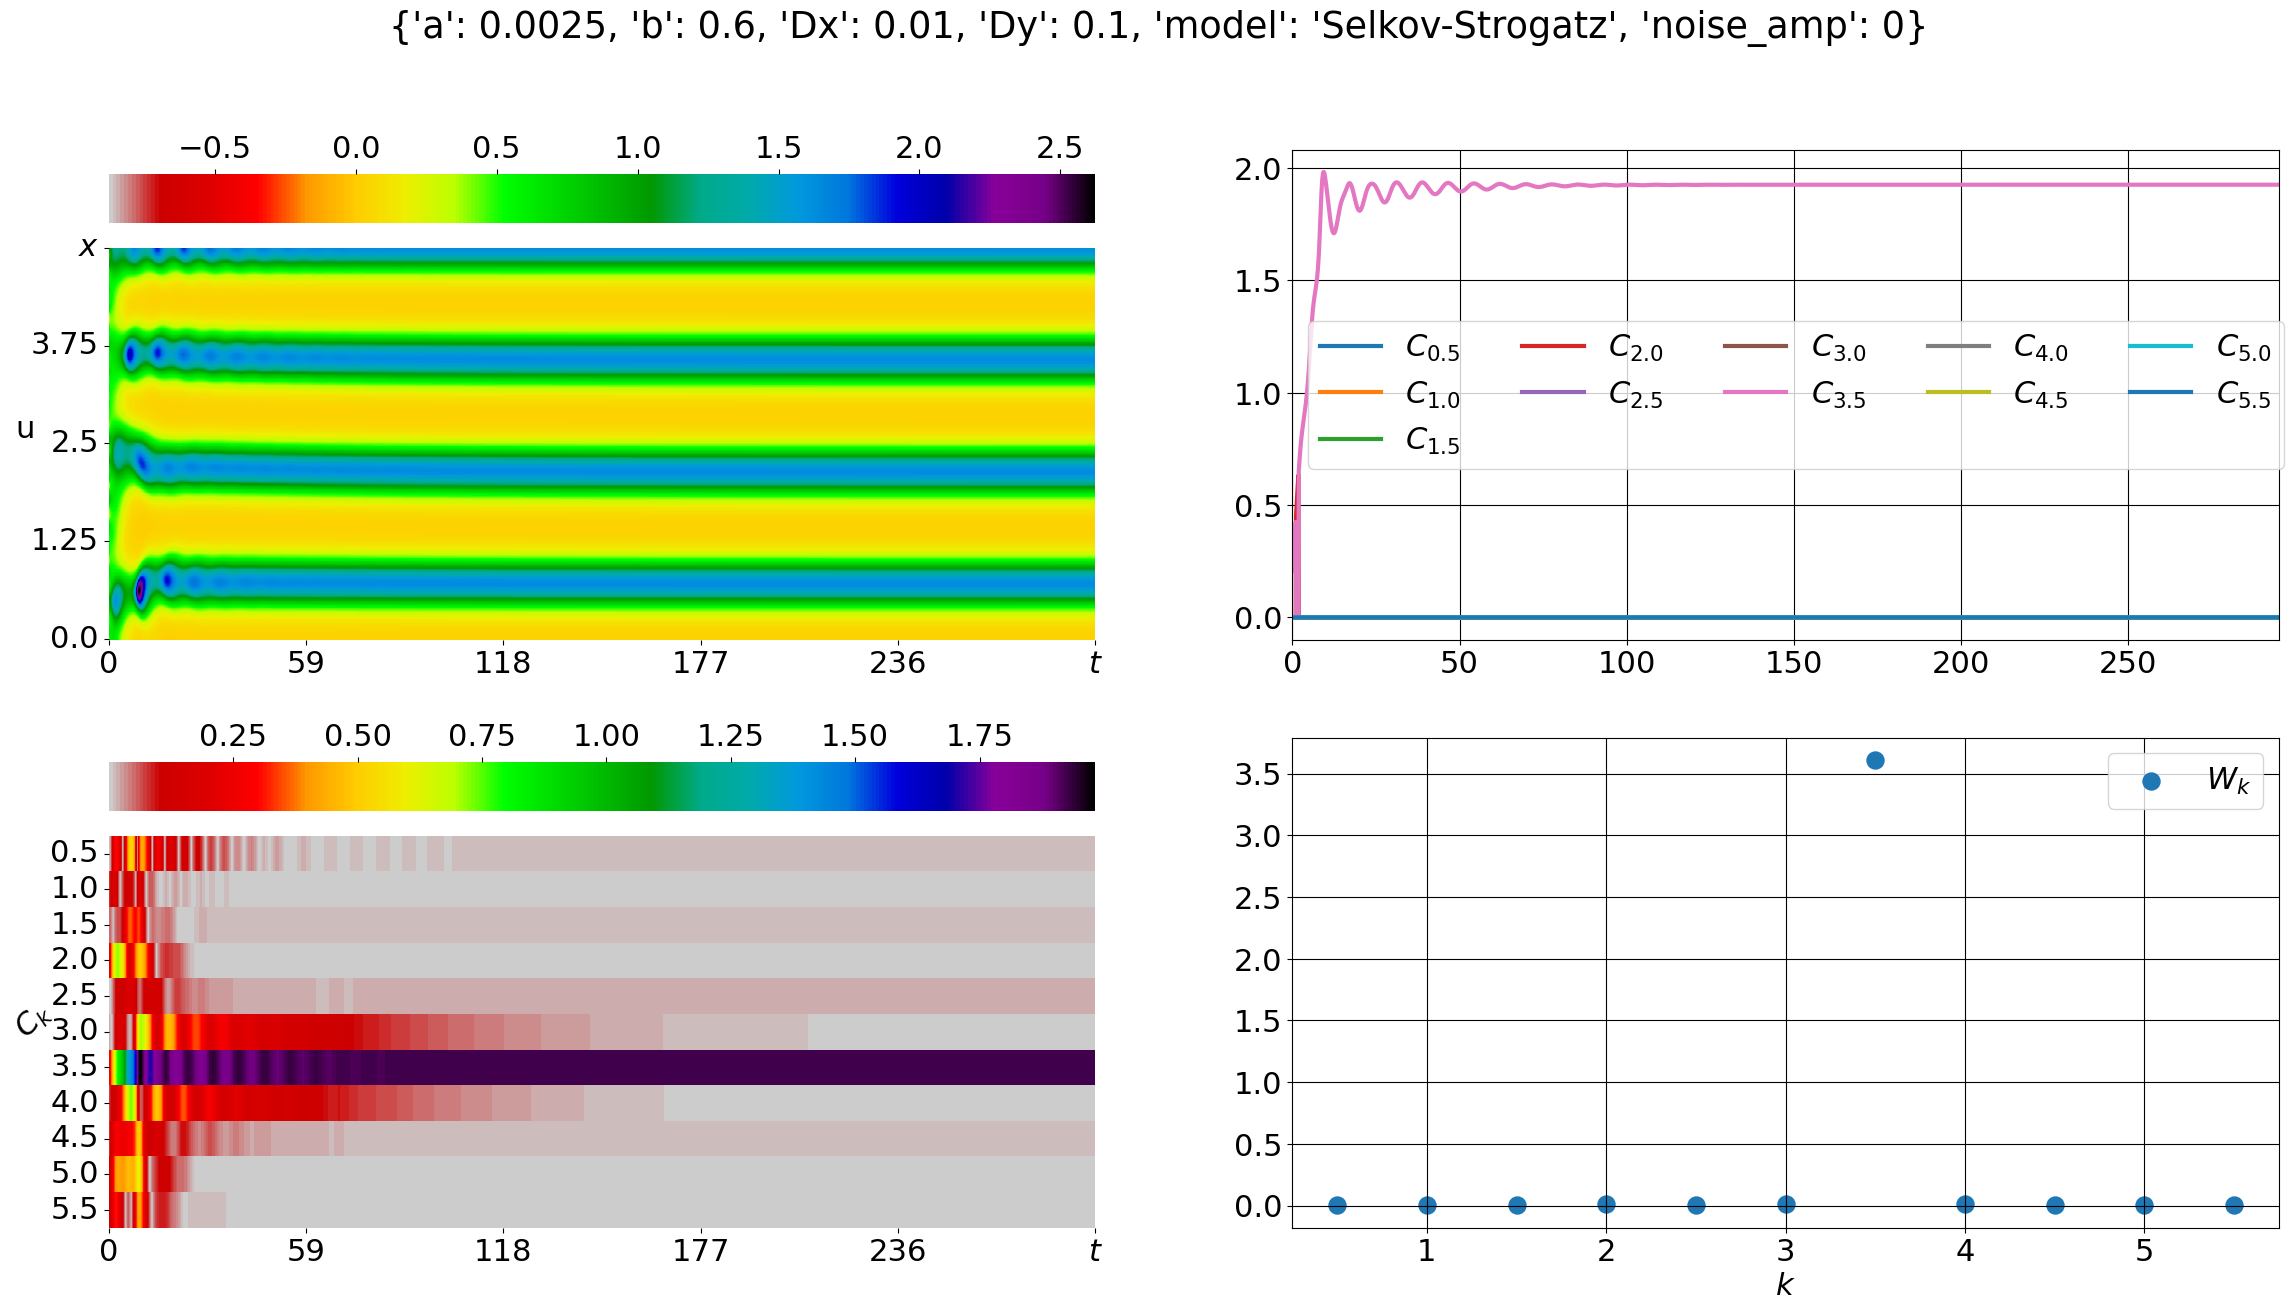

In [254]:
exxx = Experiment().fill_from(res_exps[3.5][-1].path_to_file, load_timelines=True)
draw_quadreega(exxx, FOURIER_KS[:11], 'u', right_border_t=300)

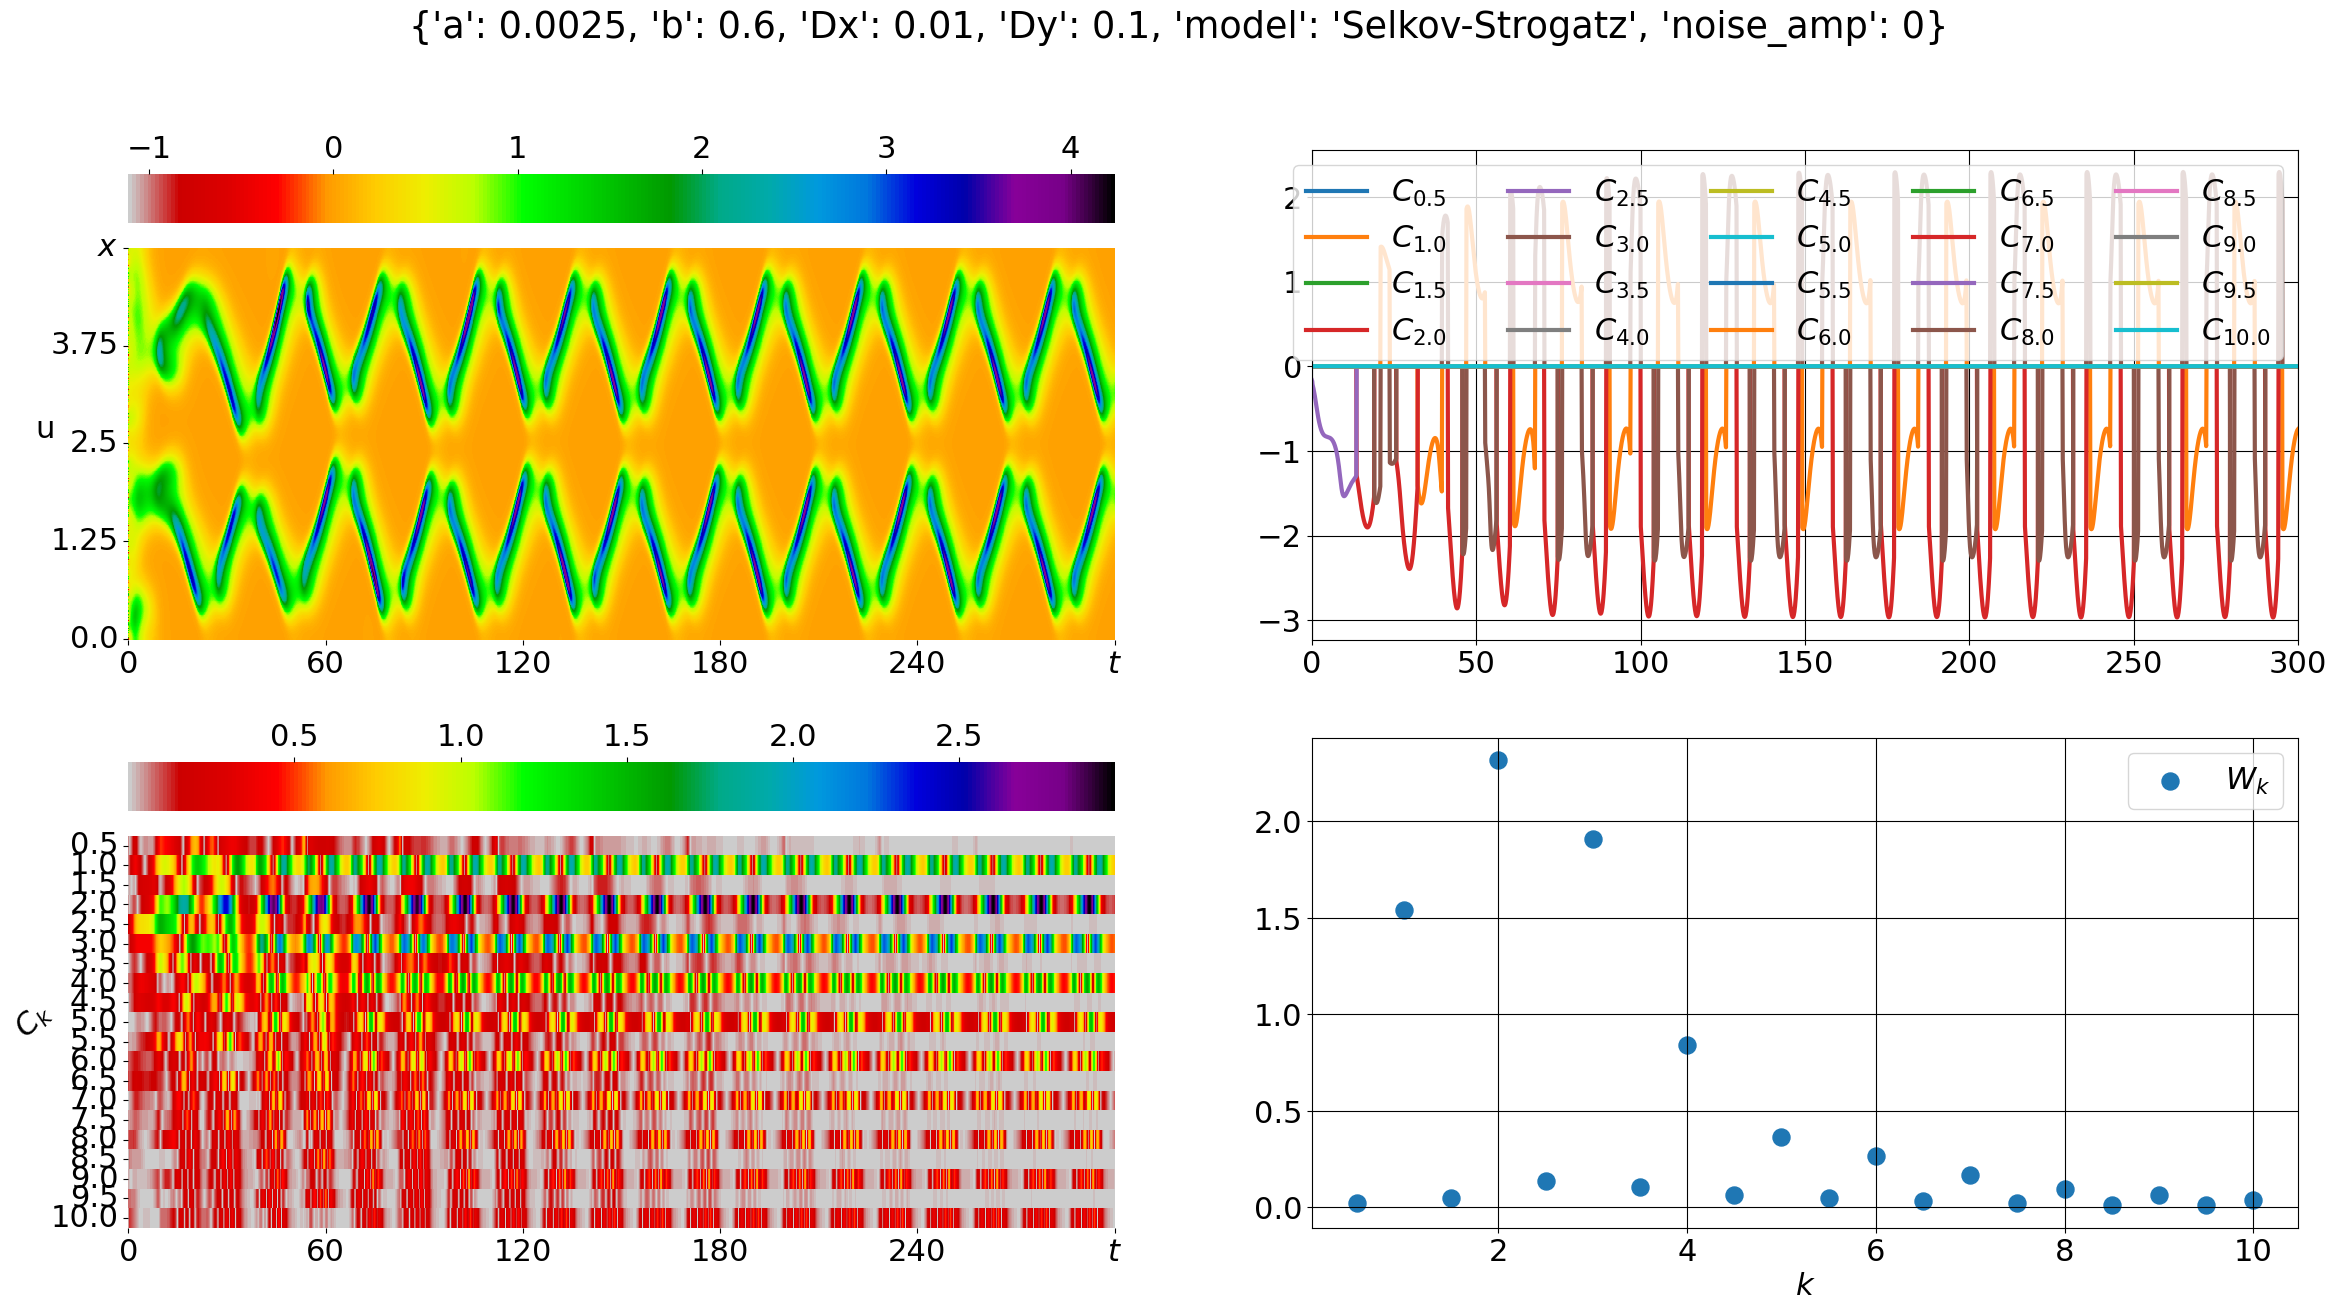

In [255]:
exxx = Experiment().fill_from(res_exps[1.0][1].path_to_file, load_timelines=True)
draw_quadreega(exxx, FOURIER_KS, 'u', right_border_t=300)

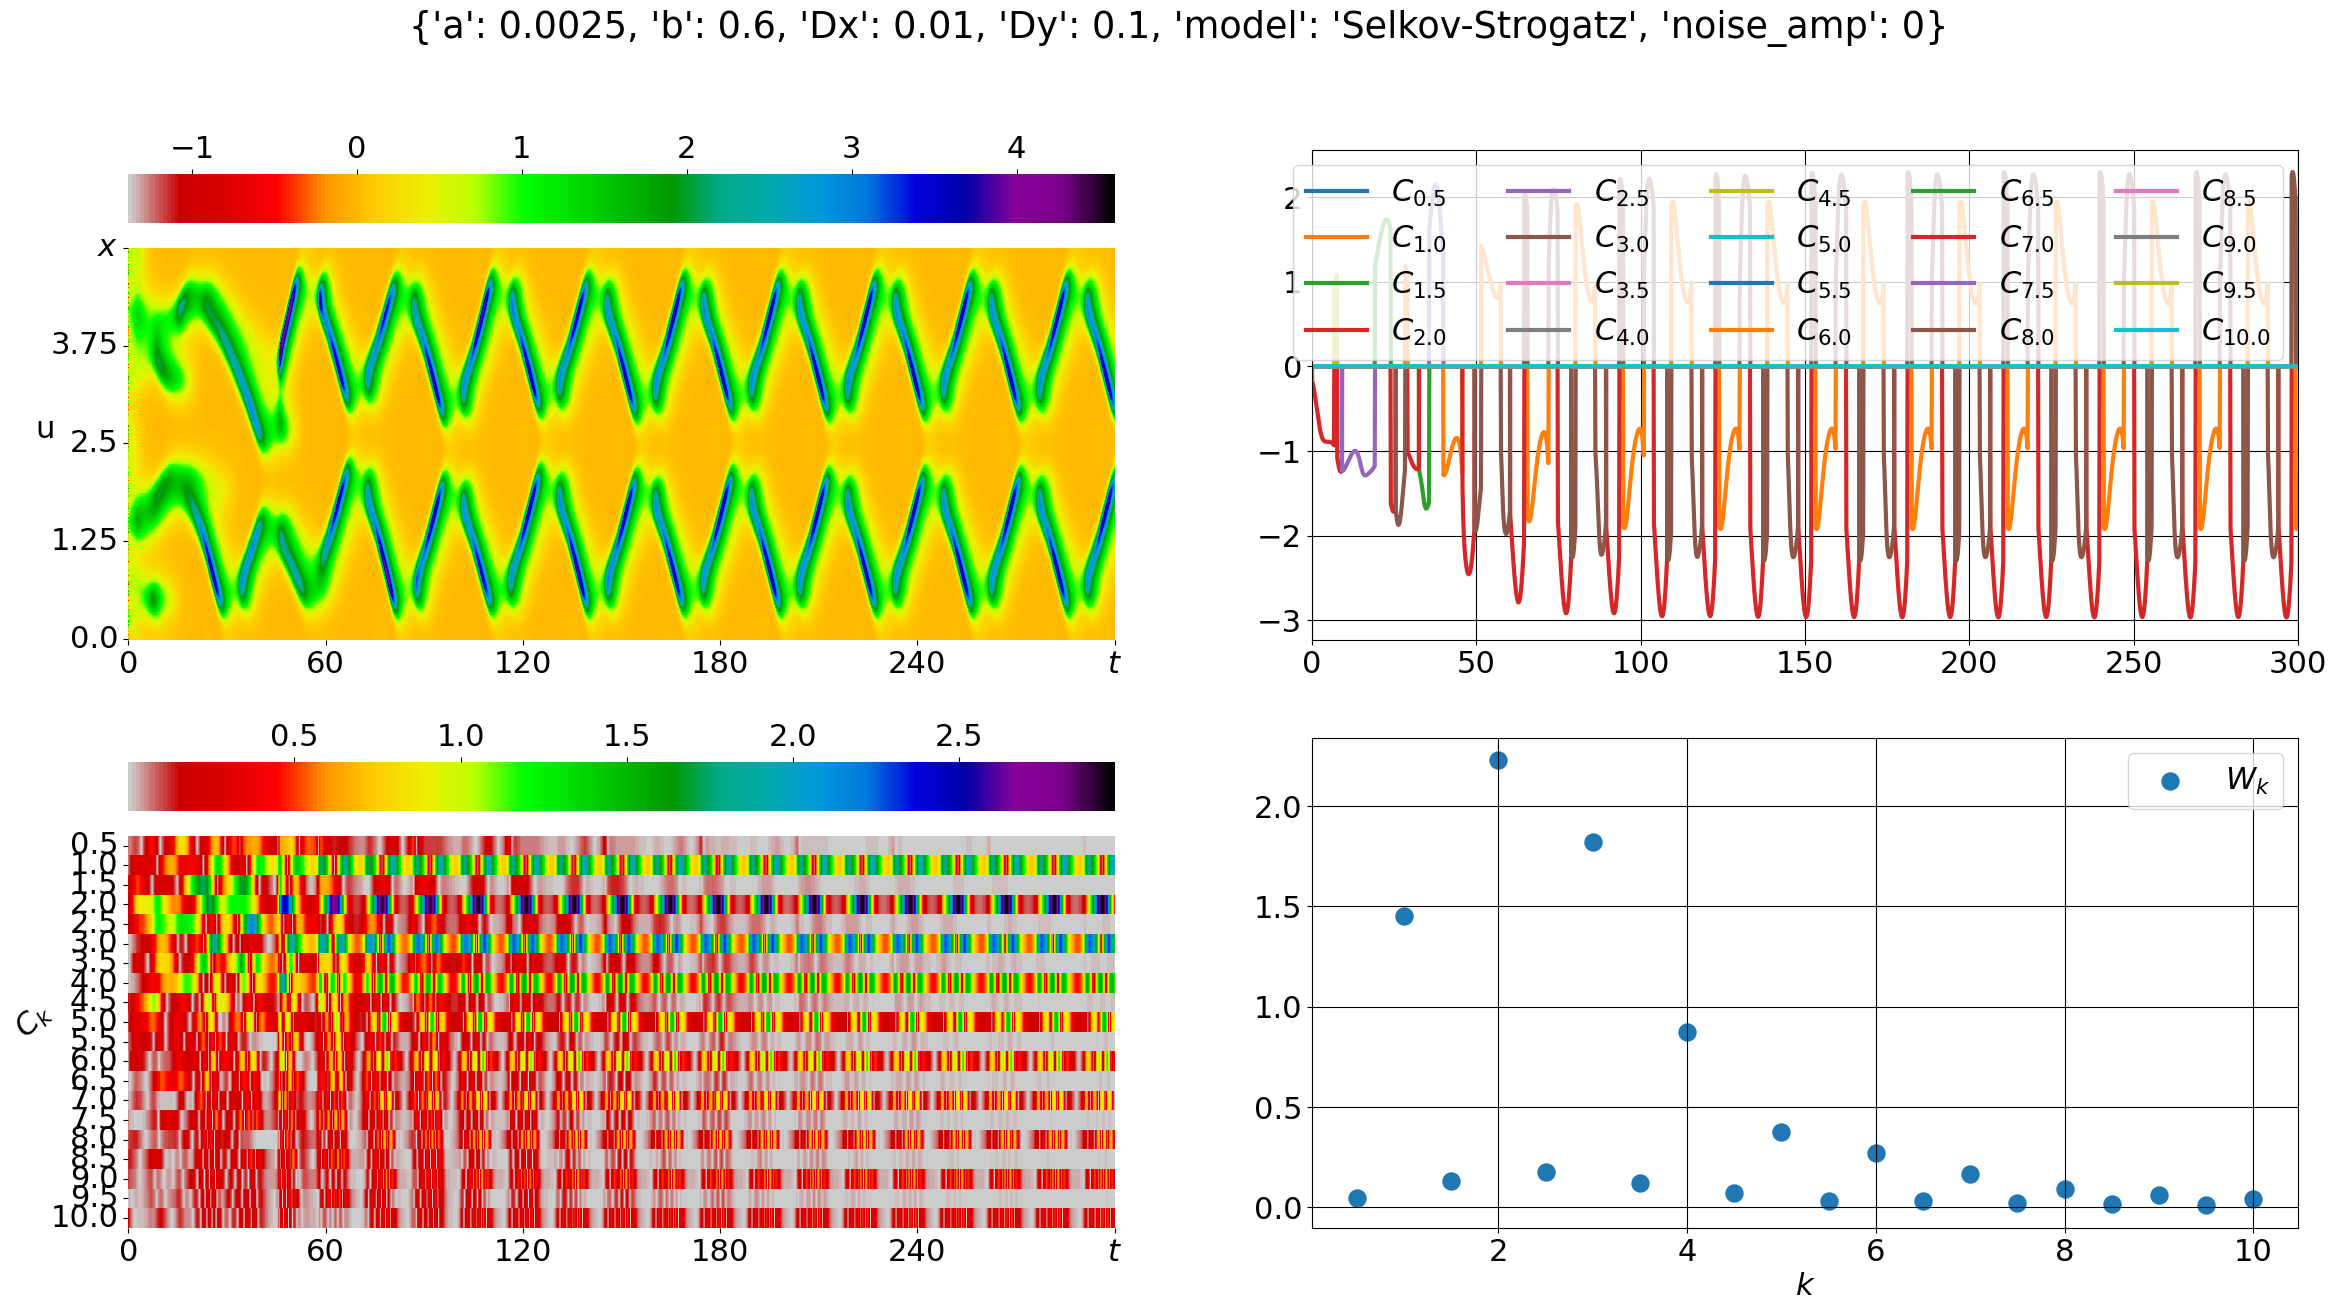

In [256]:
exxx = Experiment().fill_from(res_exps[1.0][-1].path_to_file, load_timelines=True)
draw_quadreega(exxx, FOURIER_KS, 'u', right_border_t=300)

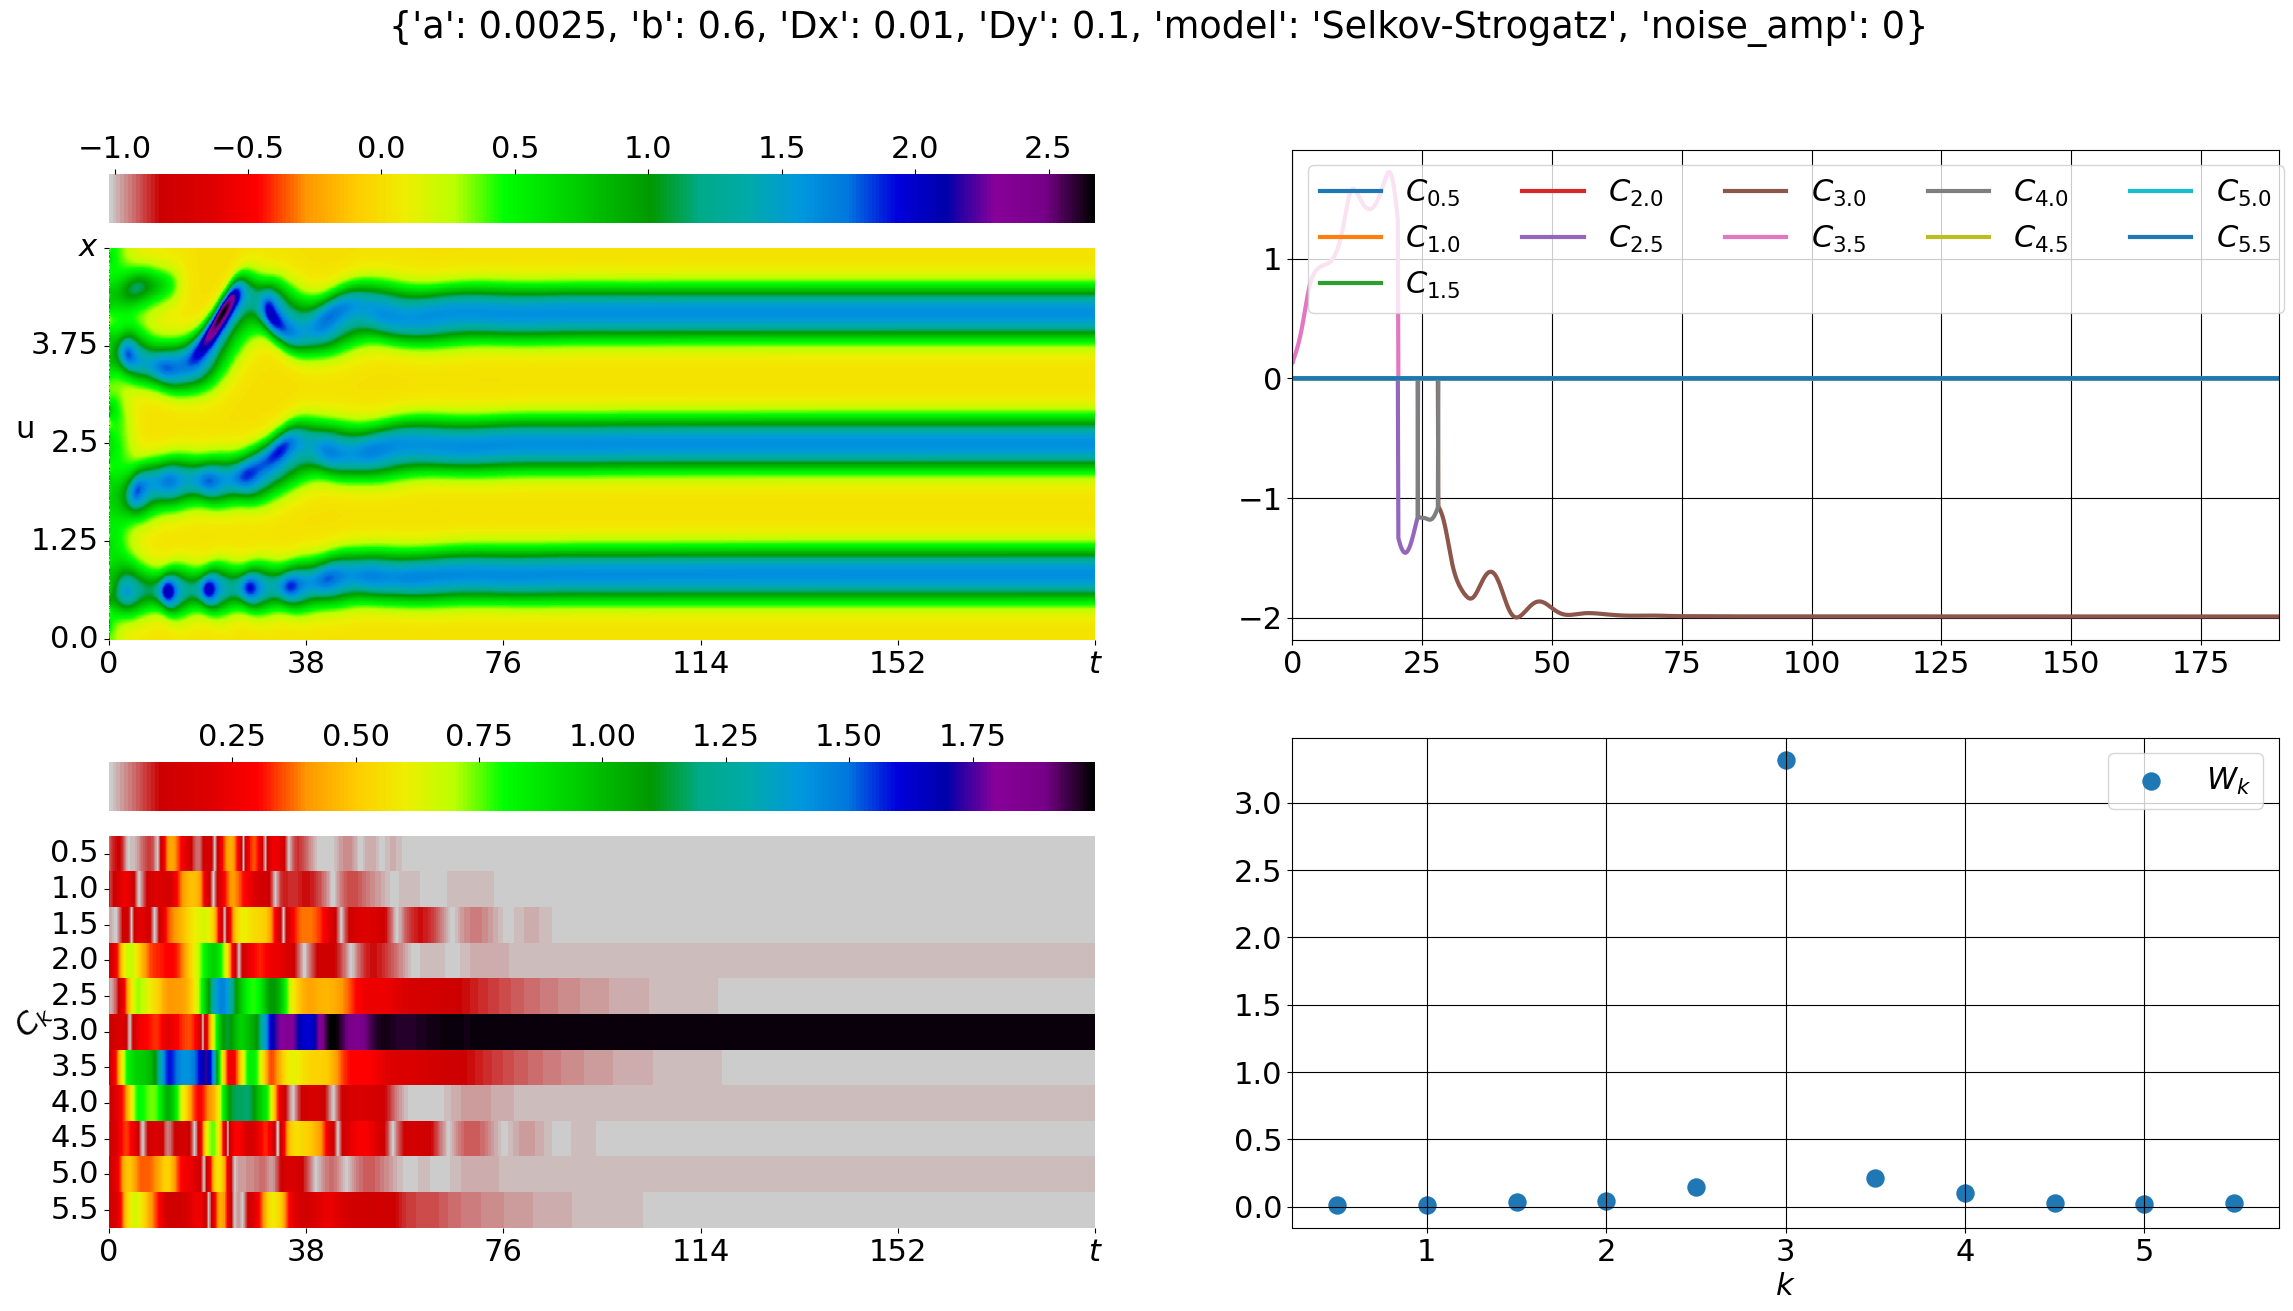

In [225]:
exxx = Experiment().fill_from(sorted_aaa[200].path_to_file, load_timelines=True)
draw_quadreega(exxx, FOURIER_KS[:11], 'u')

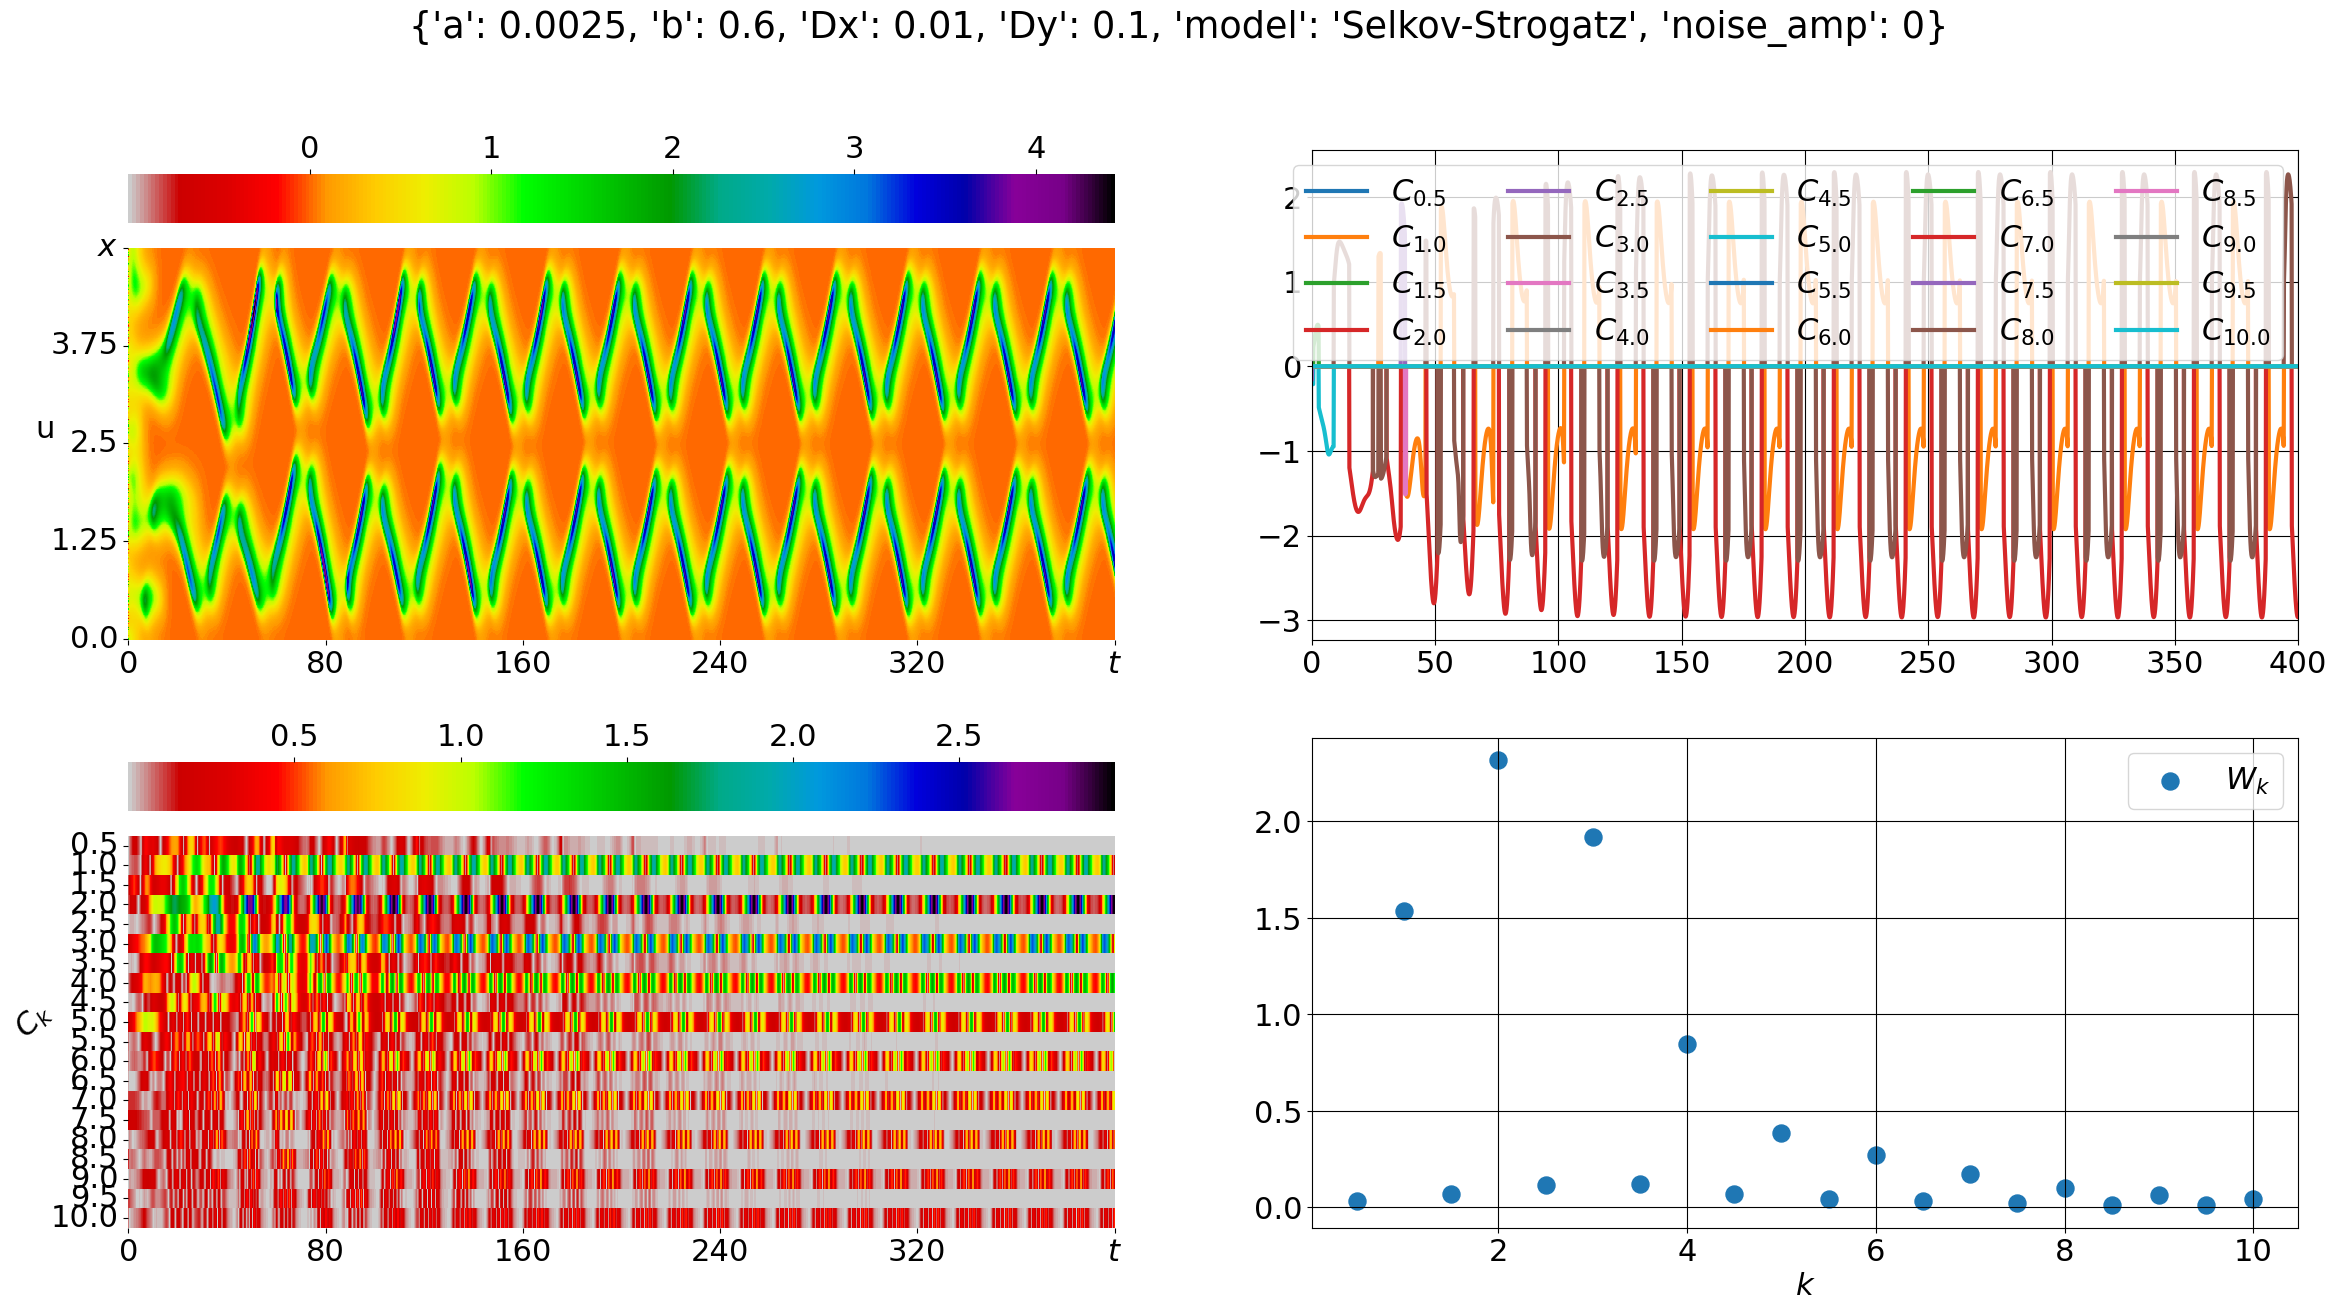

In [234]:
exxx = Experiment().fill_from(sorted_aaa[490].path_to_file, load_timelines=True)
draw_quadreega(exxx, FOURIER_KS, 'u', right_border_t=400)

dict_keys([4.5, 5.0, 5.5])


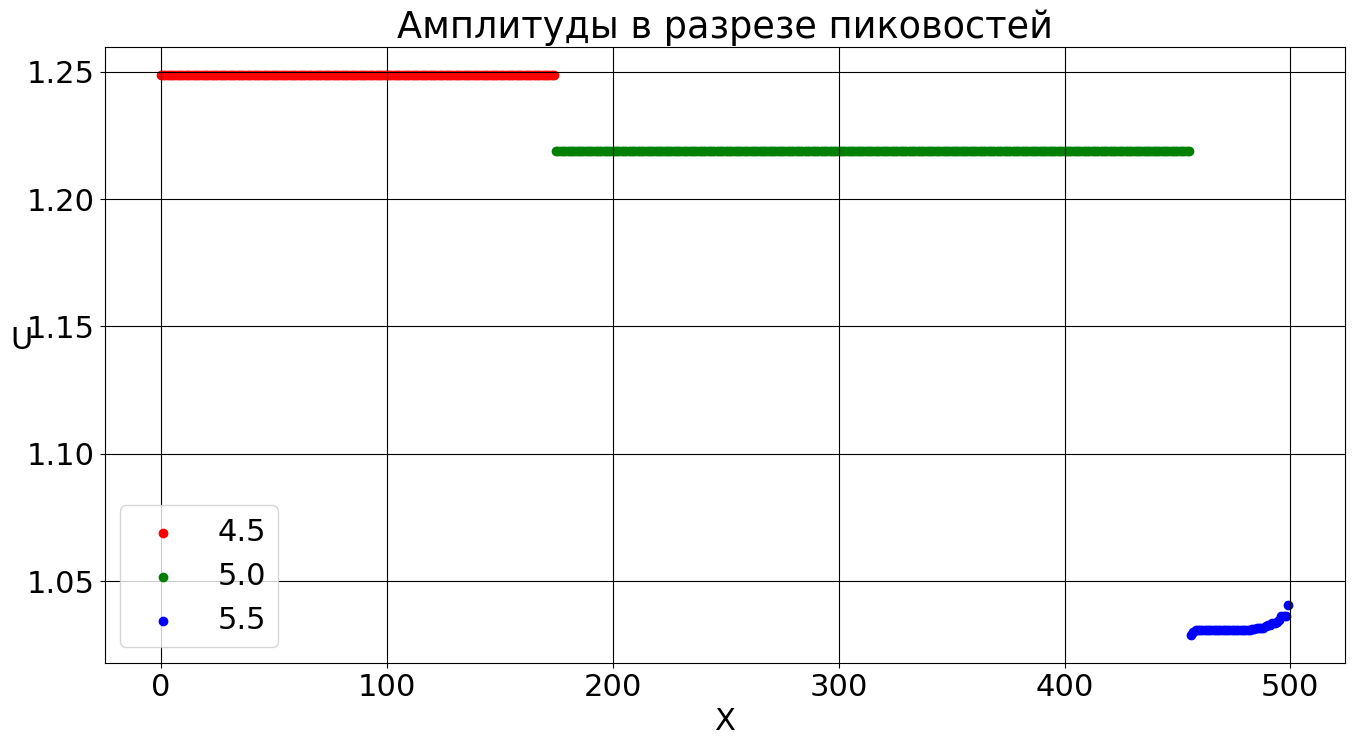

In [266]:
res = defaultdict(list)
res_exps = defaultdict(list)
for exp in params_to_exps[(0.015, 1.15)]:
    pcks = calc_peaks_by_Fourier(exp,var='u', max_peaks_count=10, min_amplitude=0.1)
    if pcks is None:
        continue
    pcks = pcks.peaks_count
    res[pcks].append(max(exp.end_values['u']) - min(exp.end_values['u']))
    res_exps[pcks].append(exp)
for k in res_exps:
    res_exps[k] = sorted(res_exps[k], key=lambda e: max(e.end_values['u']) - min(e.end_values['u']))
print(res.keys())
ax = plt.gca()
c = ['r','g','b','k']
summ = 0
for i, (k, v) in enumerate(res.items()):

    ax.scatter(range(summ, summ+len(v)), sorted(v), c=c[i%4], label=f'{k}')
    summ+=len(v)
ax.set_xlabel('X')
ax.set_ylabel('U', rotation=0)
ax.set_title('Амплитуды в разрезе пиковостей')
plt.legend()
plt.show()

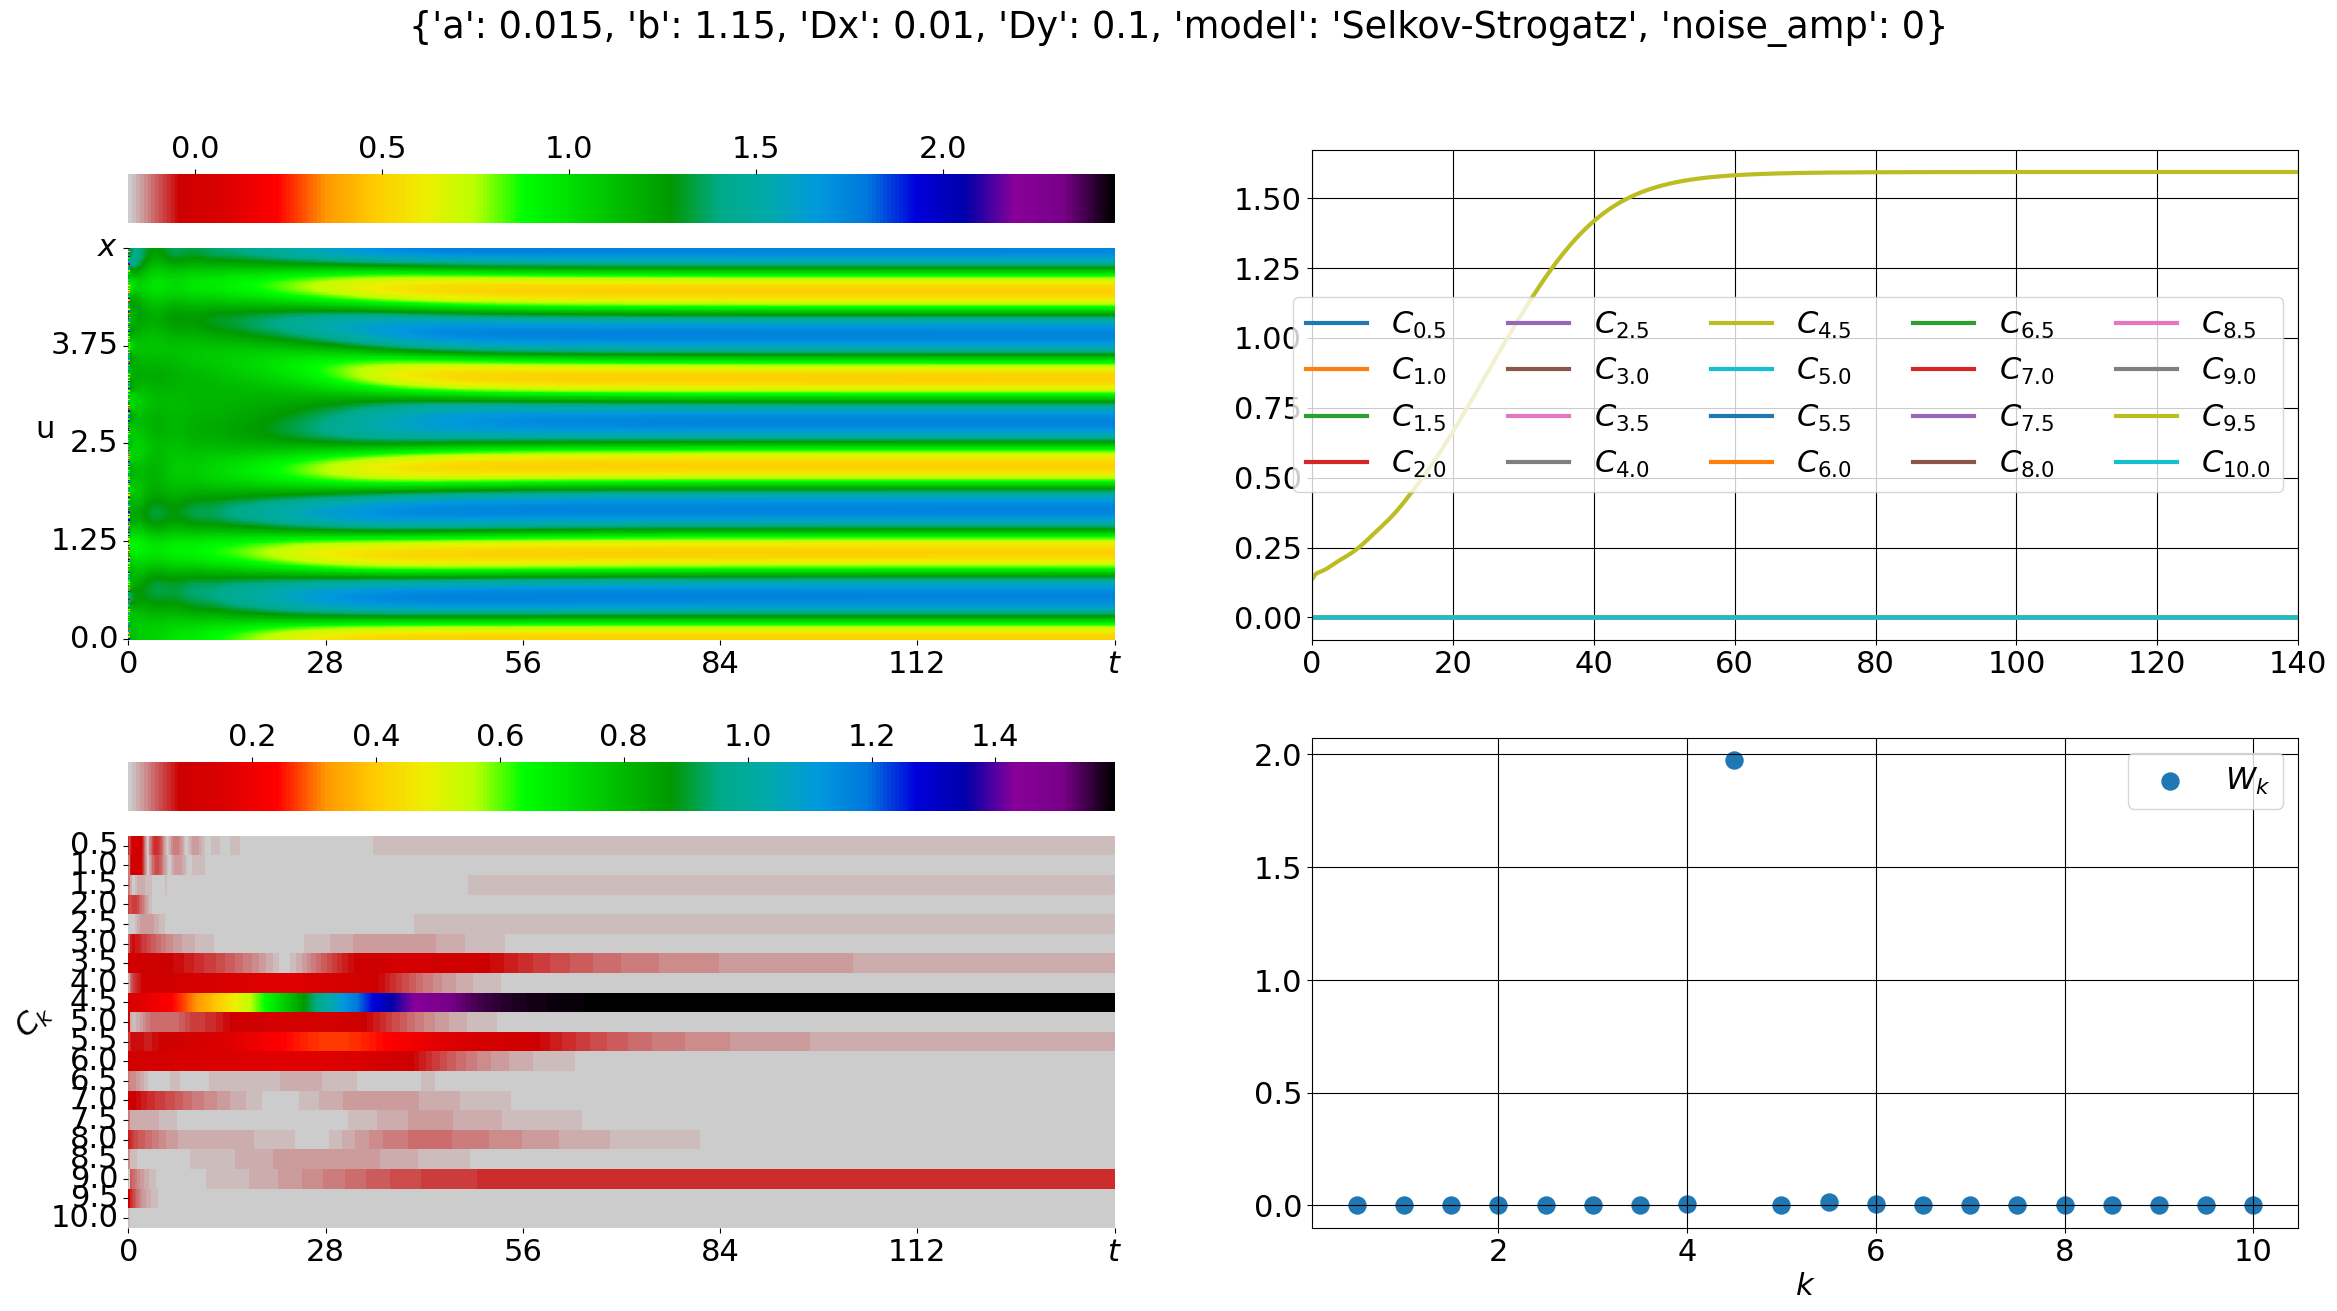

In [267]:
exxx = Experiment().fill_from(res_exps[4.5][0].path_to_file, load_timelines=True)
draw_quadreega(exxx, FOURIER_KS, 'u', right_border_t=400)

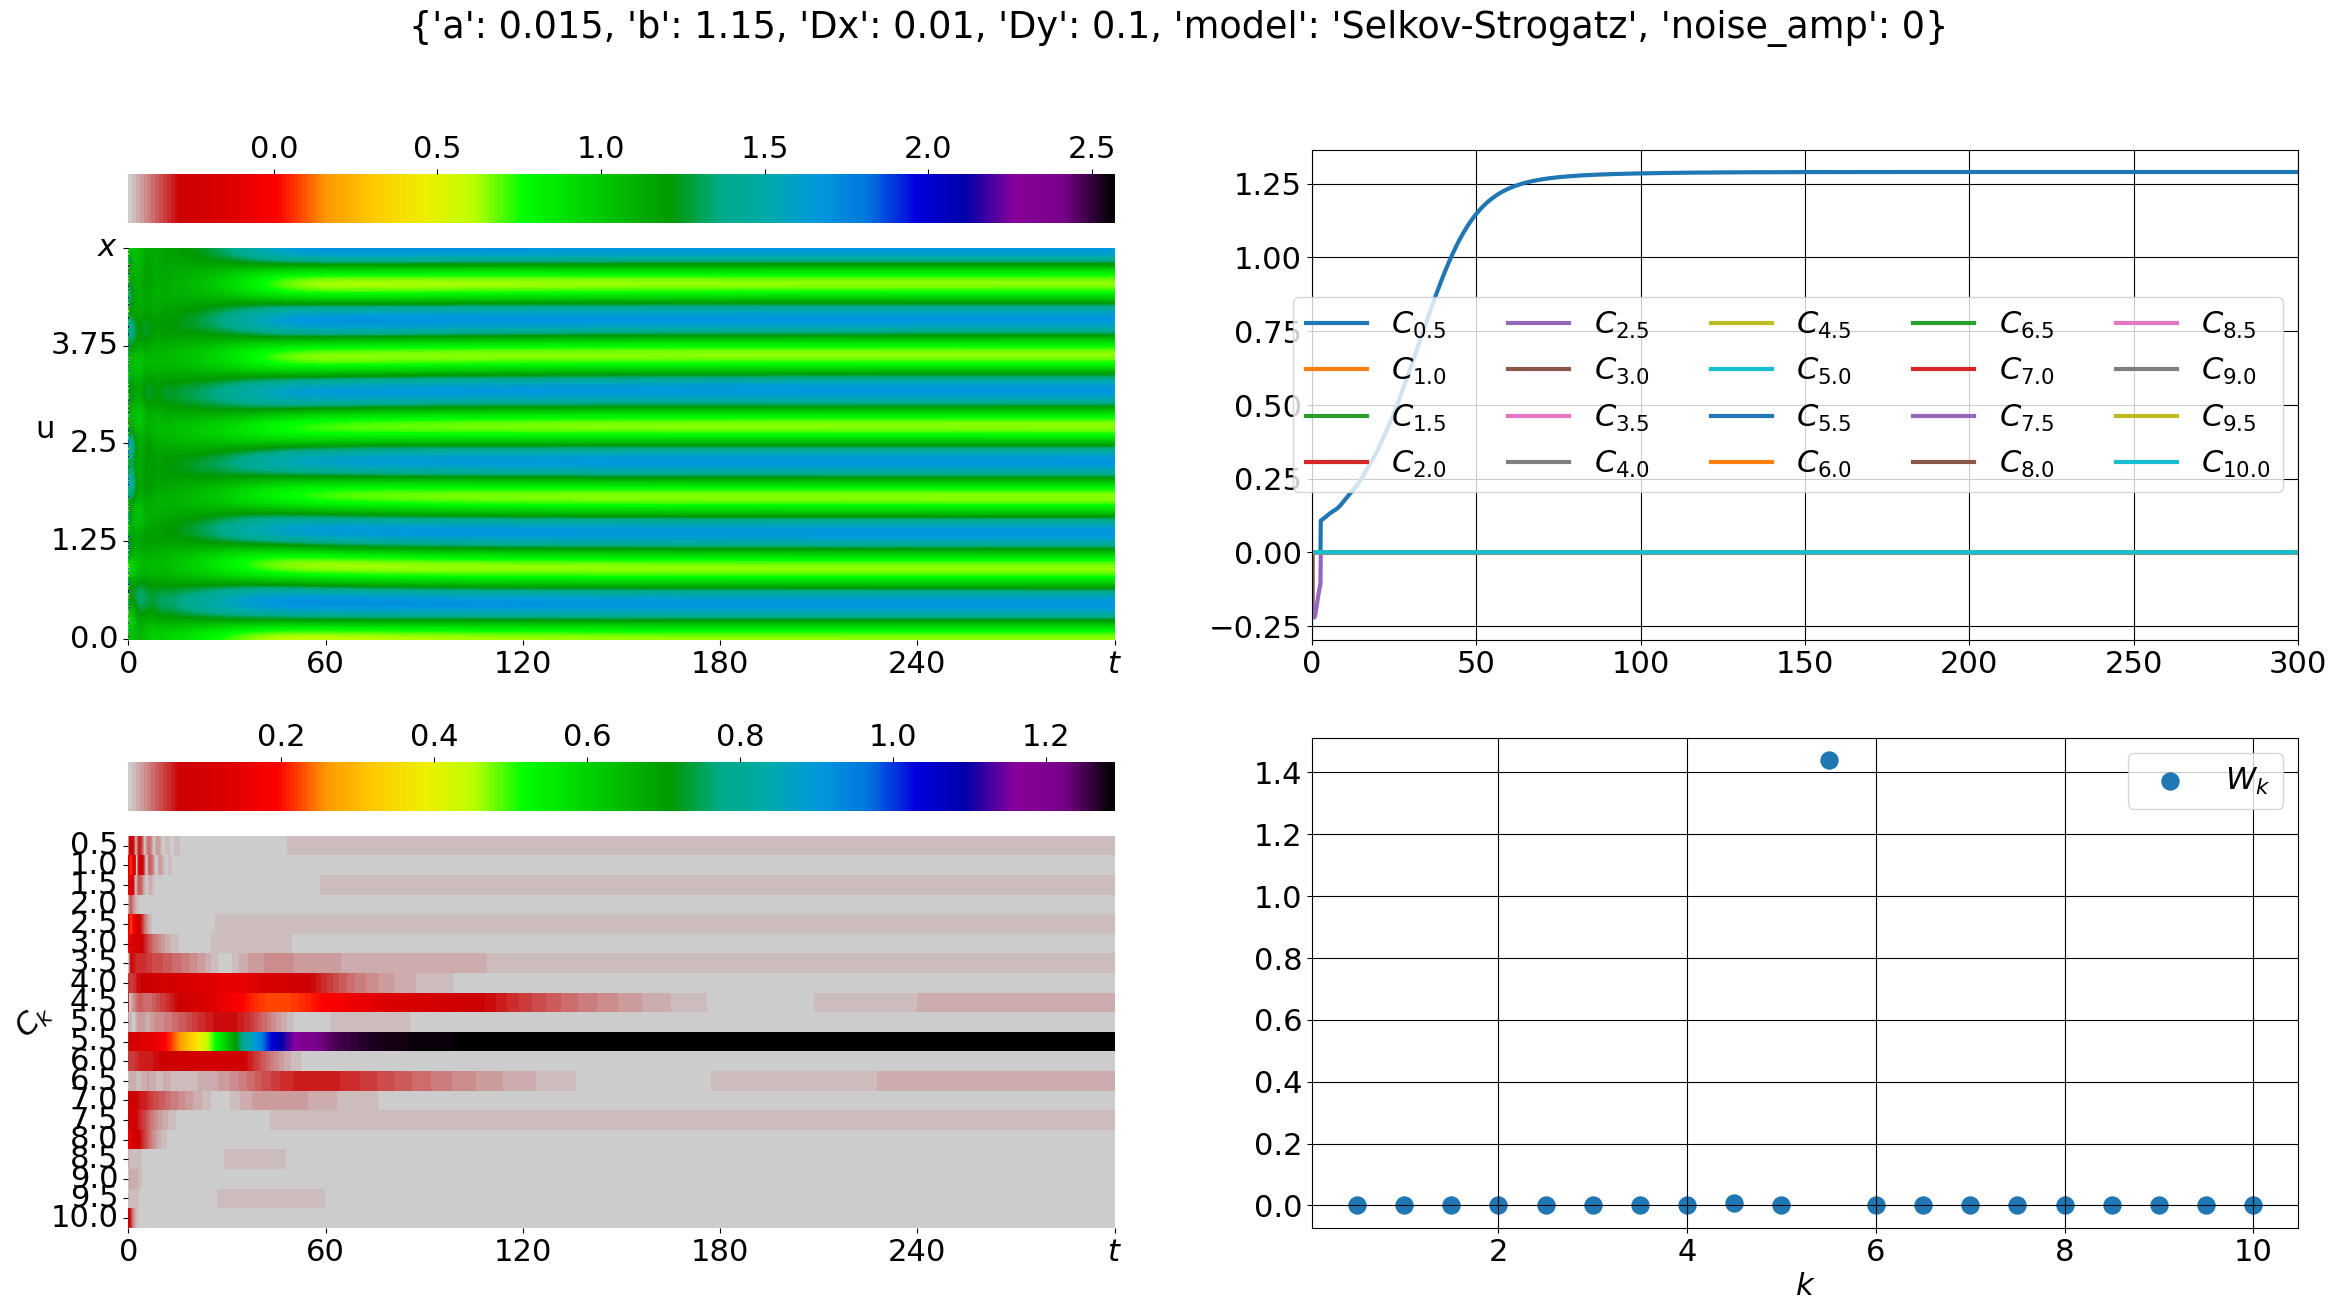

In [268]:
exxx = Experiment().fill_from(res_exps[5.5][0].path_to_file, load_timelines=True)
draw_quadreega(exxx, FOURIER_KS, 'u')

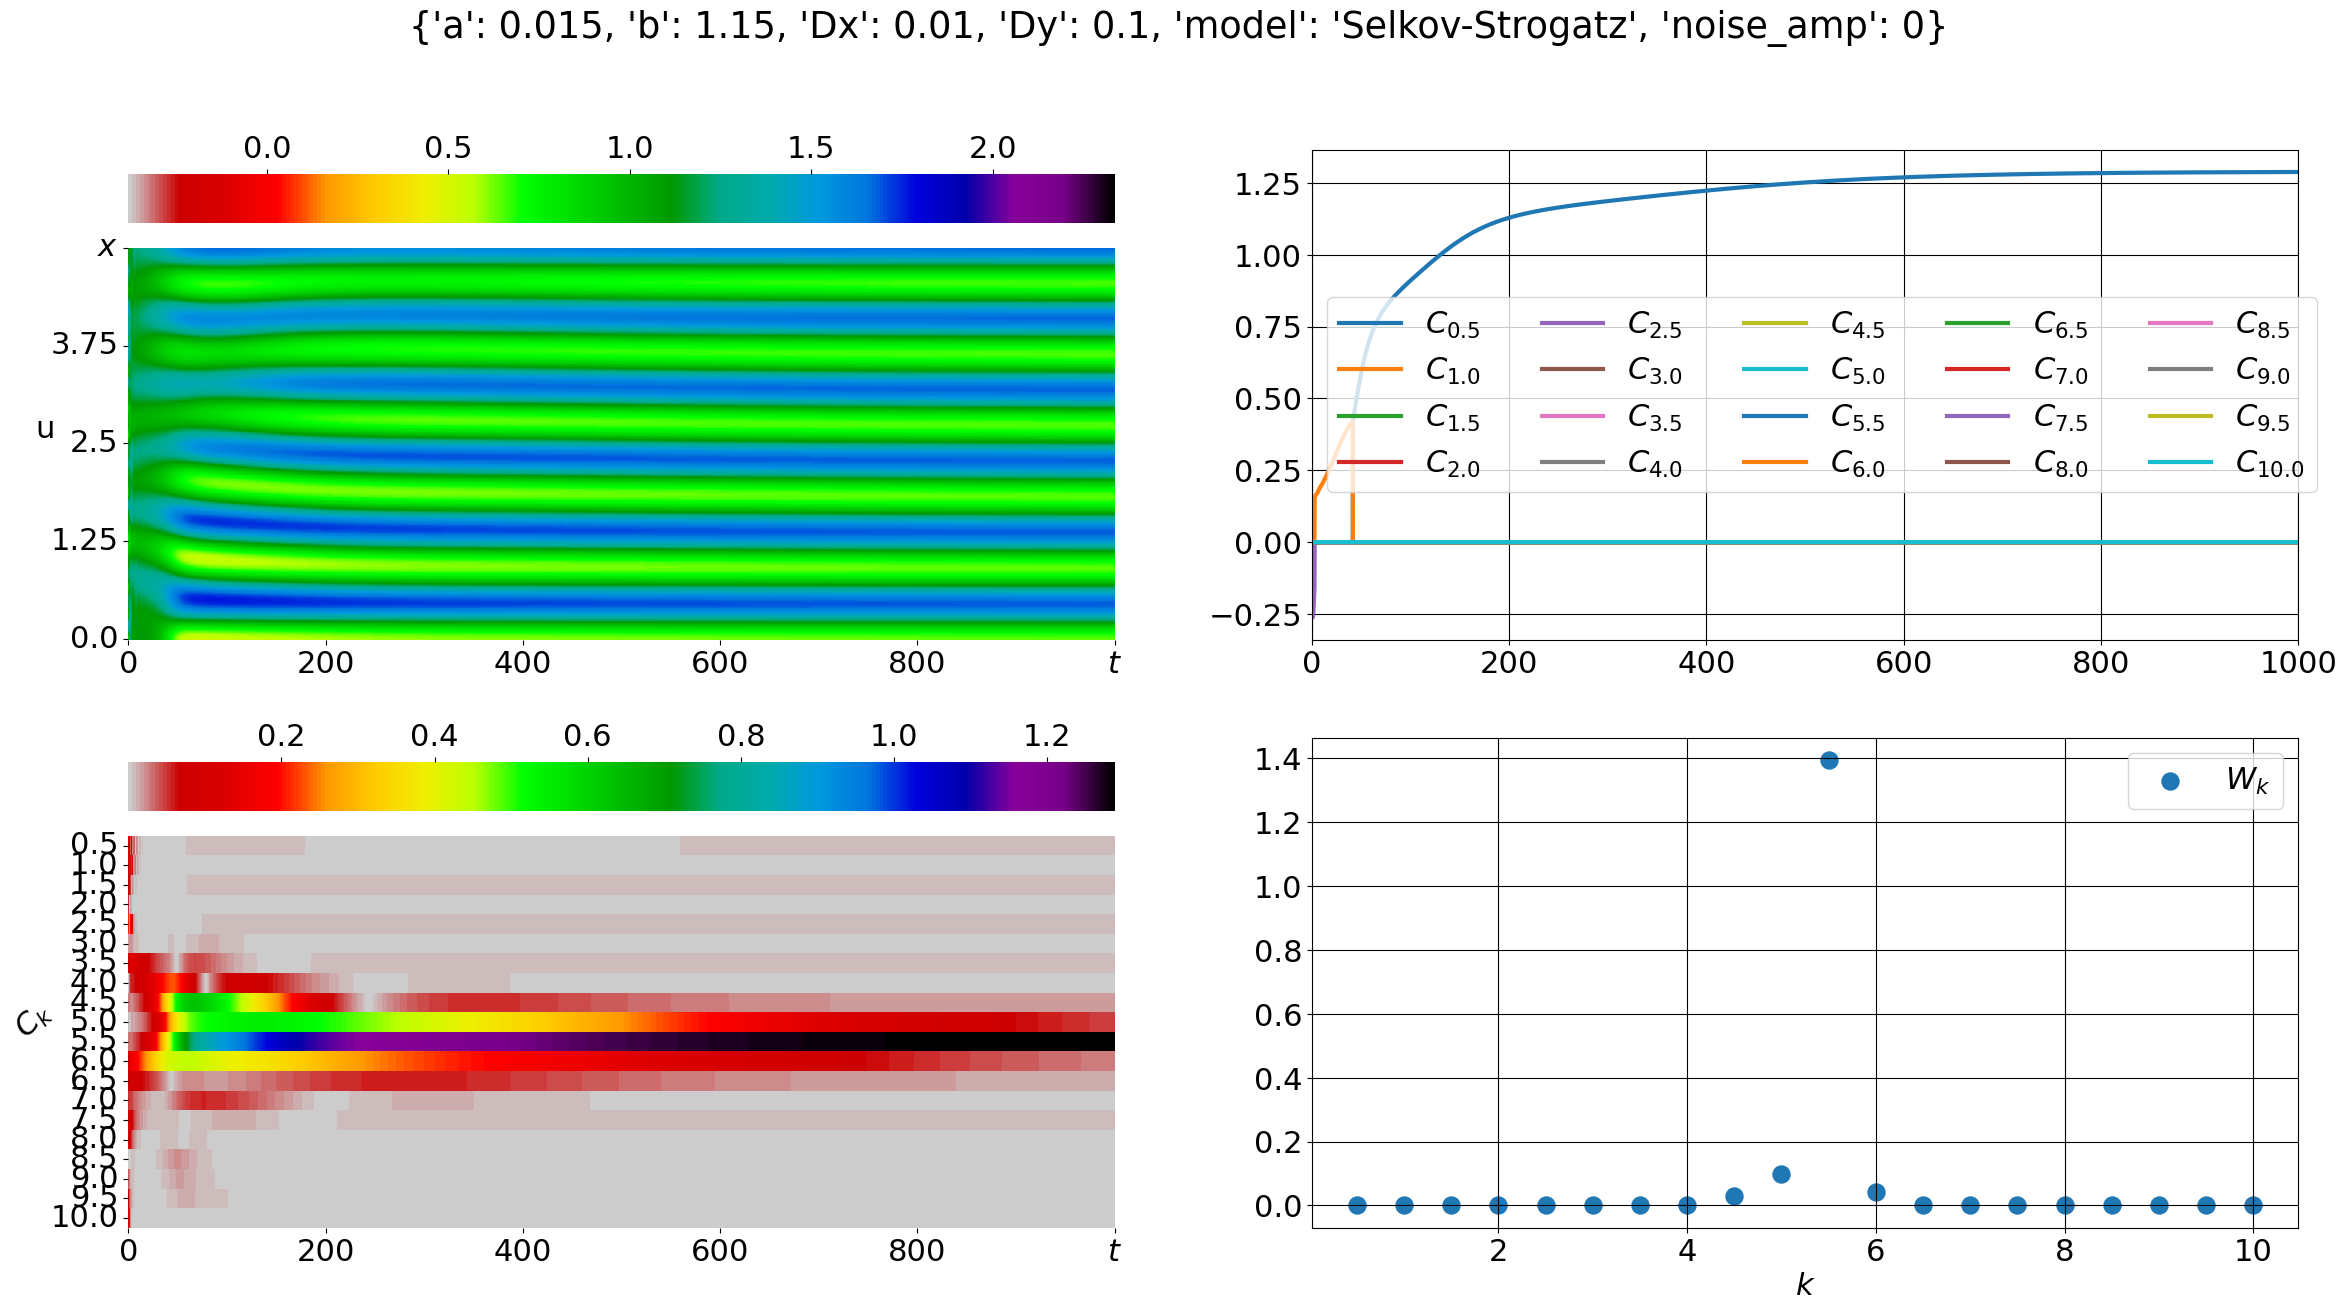

In [269]:
exxx = Experiment().fill_from(res_exps[5.5][-1].path_to_file, load_timelines=True)
draw_quadreega(exxx, FOURIER_KS, 'u')

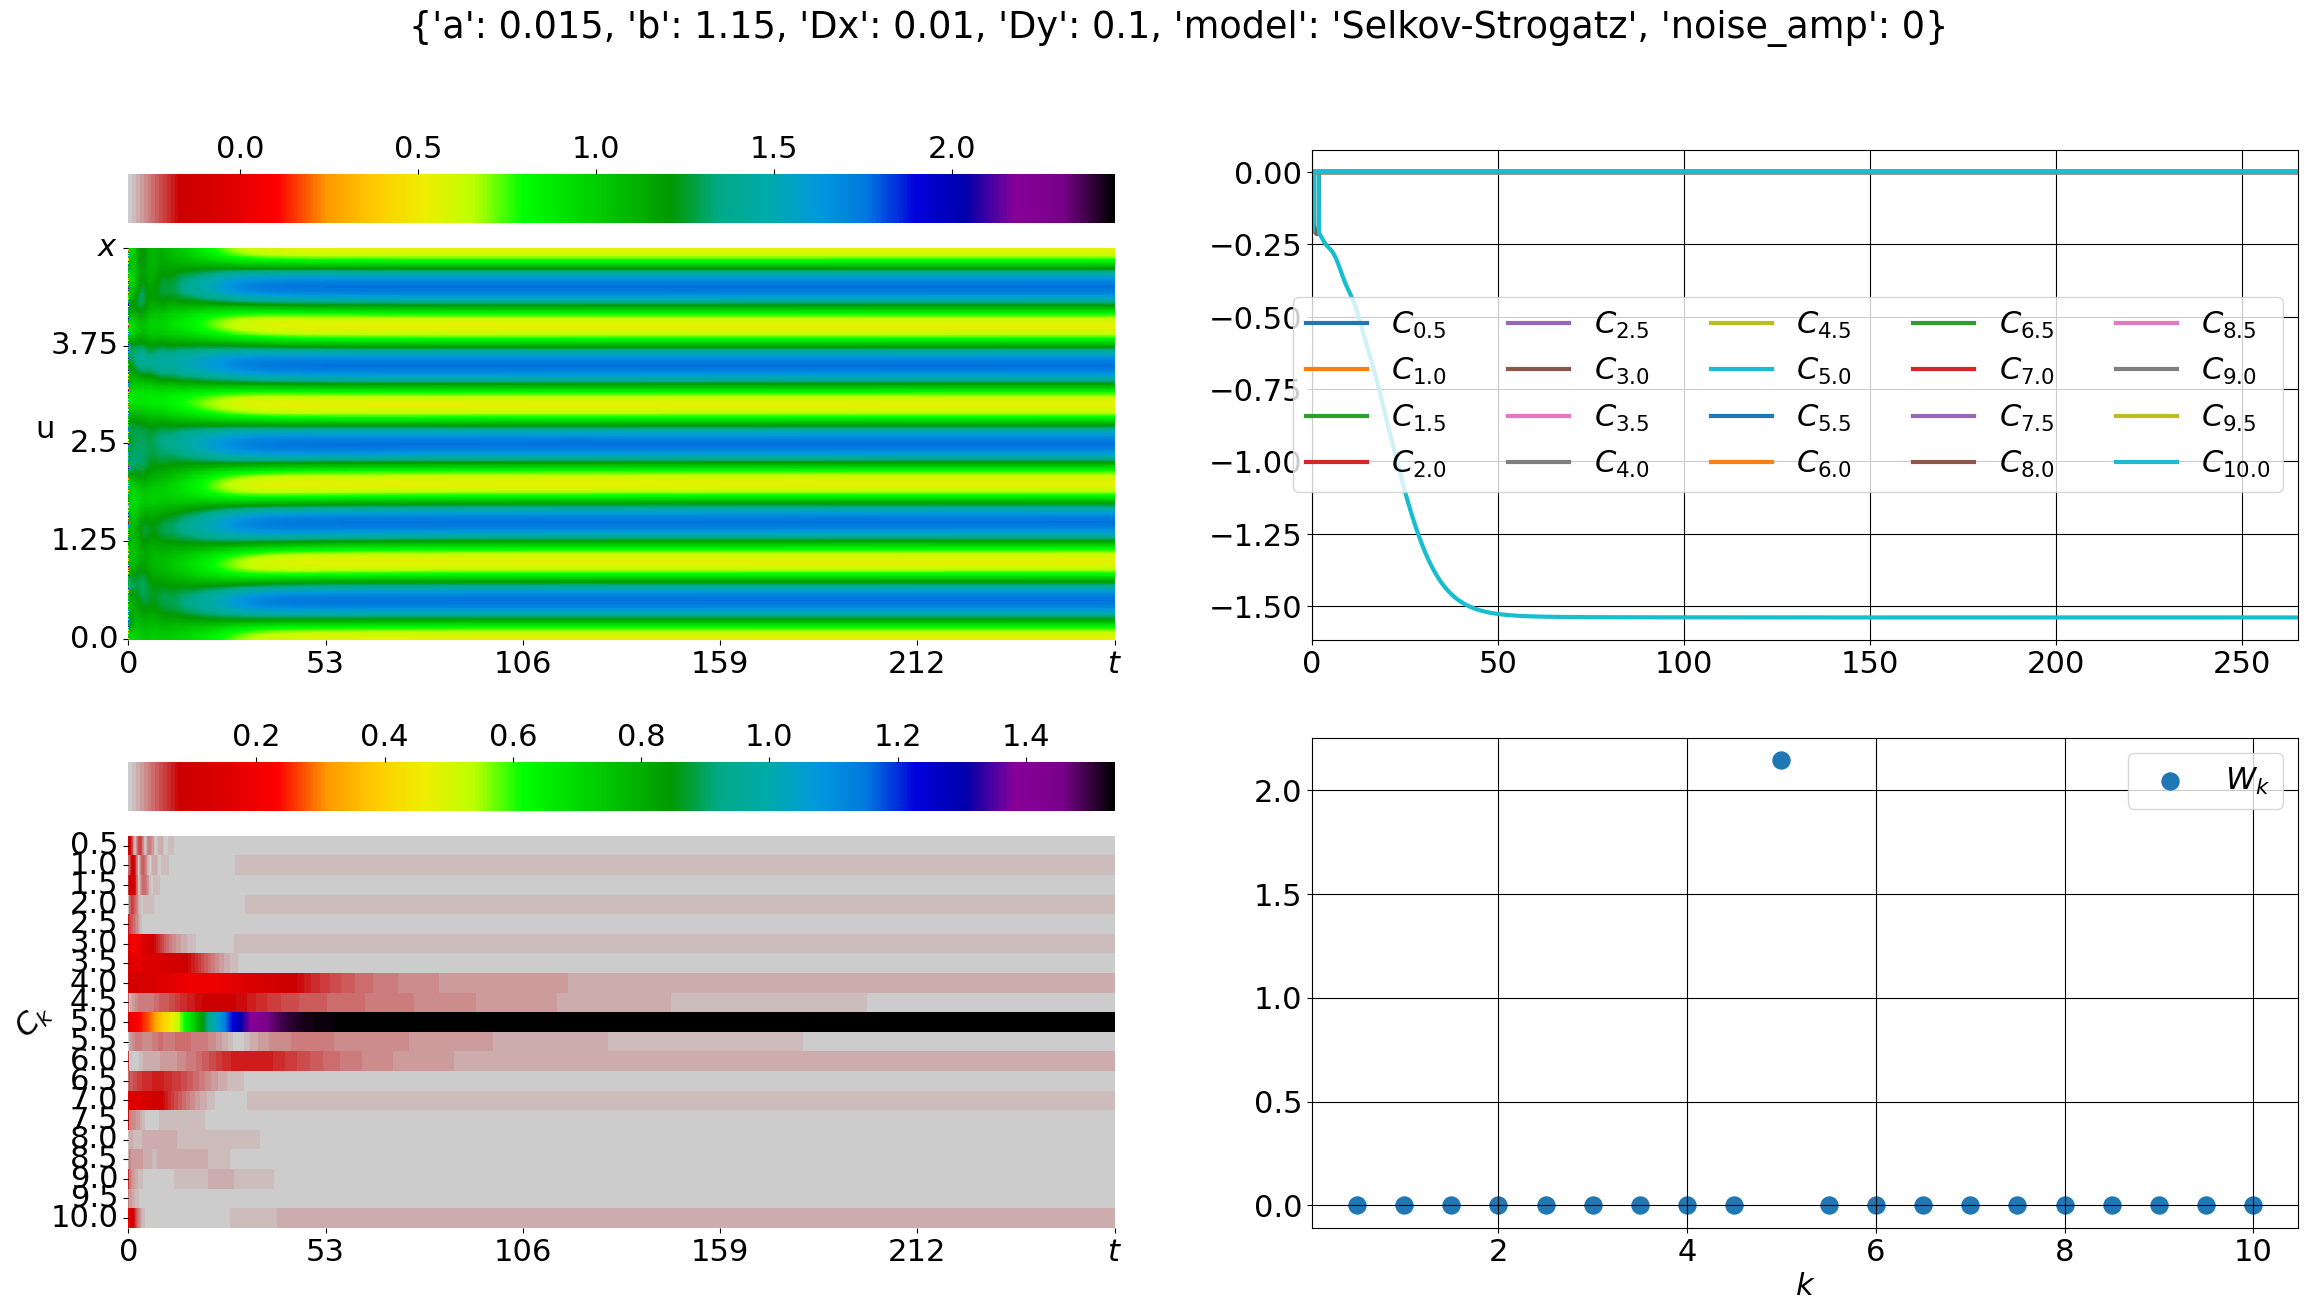

In [270]:
exxx = Experiment().fill_from(res_exps[5.0][-1].path_to_file, load_timelines=True)
draw_quadreega(exxx, FOURIER_KS, 'u')